In [1]:
print("strawberry")

count = 0

import torch
print(count); count += 1
import numpy as np
print(count); count += 1
import torch.nn.functional as F
print(count); count += 1

# dataset
from twaidata.torchdatasets.in_ram_ds import MRISegmentation2DDataset, MRISegmentation3DDataset
print(count); count += 1
from torch.utils.data import DataLoader, random_split, ConcatDataset
print(count); count += 1

# model
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_deterministic import HyperMapp3r
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_DDU import HyperMapp3rDDU
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_SSN import HyperMapp3rSSN
print(count); count += 1

# augmentation and pretrain processing
from trustworthai.utils.augmentation.standard_transforms import RandomFlip, GaussianBlur, GaussianNoise, \
                                                            RandomResizeCrop, RandomAffine, \
                                                            NormalizeImg, PairedCompose, LabelSelect, \
                                                            PairedCentreCrop, CropZDim
print(count); count += 1
# loss function
# from trustworthai.utils.losses_and_metrics.per_individual_losses import (
#     log_cosh_dice_loss,
#     TverskyLoss,
#     FocalTverskyLoss,
#     DiceLossMetric
# )
from trustworthai.utils.losses_and_metrics.dice_loss import DiceLossWithWeightedEmptySlices

print(count); count += 1

from torch.nn import BCELoss, MSELoss, BCEWithLogitsLoss
print(count); count += 1

# fitter
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

print(count); count += 1
import pytorch_lightning as pl
print(count); count += 1

# misc
import os
print(count); count += 1
import torch
print(count); count += 1
import matplotlib.pyplot as plt
print(count); count += 1
from torchinfo import summary
import argparse

import torch.nn as nn
from torchmetrics import Metric
import math

from trustworthai.utils.plotting.saving_plots import save
from trustworthai.utils.print_and_write_func import print_and_write

from tqdm import tqdm
from tqdm import tqdm
import difflib
import numpy as np
import os
import SimpleITK as sitk
import scipy.spatial
import seaborn as sns
import pandas as pd

print("banana")

strawberry
0
1
2
3
4
5
6
7
8
9
10
11
12
13
banana


In [2]:
import shlex
def construct_parser():
    parser = argparse.ArgumentParser(description = "train models")
    
    # folder arguments
    parser.add_argument('--ckpt_dir', default='s2208943/results/revamped_models/', type=str)
    parser.add_argument('--model_name', default=None, type=str)
    
    # data generation arguments
    parser.add_argument('--dataset', default='ed', type=str)
    parser.add_argument('--seed', default=3407, type=int)
    parser.add_argument('--test_split', default=0.15, type=float)
    parser.add_argument('--val_split', default=0.15, type=float)
    parser.add_argument('--empty_slice_retention', default=0.1, type=float)
    
    # model specific parameters SSN
    parser.add_argument('--ssn_rank', default=15, type=int)
    parser.add_argument('--ssn_epsilon', default=1e-5, type=float)
    parser.add_argument('--ssn_mc_samples', default=10, type=int)
    parser.add_argument('--ssn_sample_dice_coeff', default=0.05, type=float)
    parser.add_argument('--ssn_pre_head_layers', default=16, type=int)
    
    # evidential loss parameters
    parser.add_argument('--kl_factor', default=0.1, type=float)
    parser.add_argument('--kl_anneal_count', default=452*4, type=int)
    
     # model specific parameters Punet
    parser.add_argument('--kl_beta', default=10.0, type=float)
    parser.add_argument('--use_prior_for_dice', default=False, type=bool)
    parser.add_argument('--punet_sample_dice_coeff', default=0.05, type=float)
    parser.add_argument('--latent_dim', default=12, type=int)
    
    # general arguments for the loss function
    parser.add_argument('--dice_factor', default=5, type=float)
    parser.add_argument('--xent_factor', default=0.01, type=float)
    parser.add_argument('--dice_empty_slice_weight', default=0.5, type=float)
    
    # general arguments for the loss function
    parser.add_argument('--loss_name', default='dice+xent', type=str)
    # parser.add_argument('--dice_factor', default=5, type=float)
    # parser.add_argument('--xent_factor', default=0.01, type=float)
    parser.add_argument('--xent_weight', default='none', type=str)
    #parser.add_argument('--dice_empty_slice_weight', default=0.5, type=float)
    parser.add_argument('--tversky_beta', default=0.7, type=float)
    parser.add_argument('--reduction', default='mean_sum', type=str)
    
    # training paradigm arguments
    parser.add_argument('--lr', default=2e-4, type=float)
    parser.add_argument('--dropout_p', default=0.0, type=float)
    parser.add_argument('--max_epochs', default=100, type=int)
    parser.add_argument('--early_stop_patience', default=15, type=int)
    parser.add_argument('--batch_size', default=32, type=int)
    parser.add_argument('--cross_validate', default=False, type=bool)
    parser.add_argument('--cv_split', default=0, type=int)
    parser.add_argument('--cv_test_fold_smooth', default=1, type=int)
    parser.add_argument('--weight_decay', default=0.0001, type=float)
    parser.add_argument('--overwrite', default=False, type=bool)
    
    return parser

In [3]:
def load_best_checkpoint(model, loss, model_ckpt_folder, punet=False):
    # this is ultimately going to need to be passed a model wrapper when I implement P-Unet....
    
    # the path to the best checkpoint is stored as a single line in a txt file along with each model
    with open(os.path.join(model_ckpt_folder, "best_ckpt.txt"), "r") as f:
        ckpt_file = os.path.join(model_ckpt_folder, f.readlines()[0][:-1].split("/")[-1])
    
    if punet:
        return PUNetLitModelWrapper.load_from_checkpoint(ckpt_file, model=model, loss=loss, 
                                    logging_metric=lambda : None)
    return StandardLitModelWrapper.load_from_checkpoint(ckpt_file, model=model, loss=loss, 
                                    logging_metric=lambda : None)

In [4]:
torch.manual_seed(1307)

### Loading the deterministic models and their data

In [5]:
from trustworthai.utils.data_preprep.dataset_pipelines import load_clinscores_data, load_data, ClinScoreDataRetriever

In [6]:
clin_retriever = ClinScoreDataRetriever()

In [7]:
split=0
train_ds_clin, val_ds_clin, test_ds_clin = clin_retriever.load_clinscores_data(
    combine_all=False,
    test_proportion=0.15, 
    validation_proportion=0.15,
    seed=3407,
    cross_validate=True,
    cv_split=split,
    cv_test_fold_smooth=1,
)

In [8]:
models_folder = "/home/s2208943/ipdis/results/cross_validated_models/"

In [9]:
all_models = os.listdir(models_folder)
model_names = [m for m in all_models if 'deterministic' in m and 'split0' in m and 'ens' not in m]

In [10]:
model_names

['deterministic_dice_split0',
 'deterministic_tversky_split0',
 'deterministic_xent_split0',
 'deterministic_dice+xent_split0',
 'deterministic_brier_split0',
 'deterministic_tversky07_split0',
 'deterministic_tversky09_split0']

### loading a model and predictions for that model

In [11]:
from trustworthai.run.model_load.load_deterministic import load_deterministic

In [12]:
def load_model(i, model_raw=None):
    model_name = model_names[i]
    print(model_name)
    model_path = models_folder + model_name + "/"

    with open(model_path + "best_ckpt.txt") as f:
        lines = f.readlines()
        args_lines = [l[:-1].split(": ") for l in lines[1:]]
        args_lines = [f'--{l[0]} {l[1]}' for l in args_lines]
        args_line = " ".join(args_lines)
        parser = construct_parser()
        args = parser.parse_args(shlex.split(args_line))

    if model_raw == None:
        model_raw, _ = load_deterministic(args)

    # load the model
    model = load_best_checkpoint(model_raw, None, model_path)
    
    return model_raw

In [13]:
model = None
model = load_model(2, model)

deterministic_xent_split0


In [14]:
xs3d_test = []
ys3d_test = []
xs3d_val = []
ys3d_val = []

for data in test_ds_clin:
    xs3d_test.append(data[0])
    ys3d_test.append(data[1][0])
    
for data in val_ds_clin:
    xs3d_val.append(data[0])
    ys3d_val.append(data[1][0])

In [15]:
def get_preds(model_index, model):
    model = load_model(model_index, model)
    test_outs = []
    val_outs = []
    
    with torch.no_grad():
        for data in test_ds_clin:
            x = data[0].swapaxes(0,1).cuda()
            out = torch.nn.functional.softmax(model(x), dim=1).cpu()
            test_outs.append(out)
        
        for data in val_ds_clin:
            x = data[0].swapaxes(0,1).cuda()
            out = torch.nn.functional.softmax(model(x), dim=1).cpu()
            val_outs.append(out)
        
    return val_outs, test_outs

### WMH challenge dataset metrics

In [16]:
def getDSC(testImage, resultImage):    
    """Compute the Dice Similarity Coefficient."""
    # testArray   = sitk.GetArrayFromImage(testImage).flatten()
    # resultArray = sitk.GetArrayFromImage(resultImage).flatten()
    testArray = testImage.view(-1).cpu().numpy()
    resultArray = resultImage.view(-1).cpu().numpy()
    
    # similarity = 1.0 - dissimilarity
    return 1.0 - scipy.spatial.distance.dice(testArray, resultArray) 
    

def getHausdorff(testImage, resultImage):
    """Compute the Hausdorff distance."""
    
    testImage = sitk.GetImageFromArray(testImage)
    resultImage = sitk.GetImageFromArray(resultImage)
    
    # Hausdorff distance is only defined when something is detected
    resultStatistics = sitk.StatisticsImageFilter()
    resultStatistics.Execute(resultImage)
    if resultStatistics.GetSum() == 0:
        return float('nan')
        
    # Edge detection is done by ORIGINAL - ERODED, keeping the outer boundaries of lesions. Erosion is performed in 2D
    eTestImage   = sitk.BinaryErode(testImage, (1,1,0) )
    eResultImage = sitk.BinaryErode(resultImage, (1,1,0) )
    
    hTestImage   = sitk.Subtract(testImage, eTestImage)
    hResultImage = sitk.Subtract(resultImage, eResultImage)    
    
    hTestArray   = sitk.GetArrayFromImage(hTestImage)
    hResultArray = sitk.GetArrayFromImage(hResultImage)   
        
    # Convert voxel location to world coordinates. Use the coordinate system of the test image
    # np.nonzero   = elements of the boundary in numpy order (zyx)
    # np.flipud    = elements in xyz order
    # np.transpose = create tuples (x,y,z)
    # testImage.TransformIndexToPhysicalPoint converts (xyz) to world coordinates (in mm)
    testCoordinates   = [testImage.TransformIndexToPhysicalPoint(x.tolist()) for x in np.transpose( np.flipud( np.nonzero(hTestArray) ))]
    resultCoordinates = [testImage.TransformIndexToPhysicalPoint(x.tolist()) for x in np.transpose( np.flipud( np.nonzero(hResultArray) ))]
        
            
    # Use a kd-tree for fast spatial search
    def getDistancesFromAtoB(a, b):    
        kdTree = scipy.spatial.KDTree(a, leafsize=100)
        return kdTree.query(b, k=1, eps=0, p=2)[0]
    
    # Compute distances from test to result; and result to test
    dTestToResult = getDistancesFromAtoB(testCoordinates, resultCoordinates)
    dResultToTest = getDistancesFromAtoB(resultCoordinates, testCoordinates)    
    
    return max(np.percentile(dTestToResult, 95), np.percentile(dResultToTest, 95))
    
    
def getLesionDetection(testImage, resultImage):    
    """Lesion detection metrics, both recall and F1."""
    testImage = sitk.GetImageFromArray(testImage)
    resultImage = sitk.GetImageFromArray(resultImage)
    
    # Connected components will give the background label 0, so subtract 1 from all results
    ccFilter = sitk.ConnectedComponentImageFilter()    
    ccFilter.SetFullyConnected(True)
    
    # Connected components on the test image, to determine the number of true WMH.
    # And to get the overlap between detected voxels and true WMH
    ccTest = ccFilter.Execute(testImage)    
    lResult = sitk.Multiply(ccTest, sitk.Cast(resultImage, sitk.sitkUInt32))
    
    ccTestArray = sitk.GetArrayFromImage(ccTest)
    lResultArray = sitk.GetArrayFromImage(lResult)
    
    # recall = (number of detected WMH) / (number of true WMH) 
    nWMH = len(np.unique(ccTestArray)) - 1
    if nWMH == 0:
        recall = 1.0
    else:
        recall = float(len(np.unique(lResultArray)) - 1) / nWMH
    
    # Connected components of results, to determine number of detected lesions
    ccResult = ccFilter.Execute(resultImage)
    lTest = sitk.Multiply(ccResult, sitk.Cast(testImage, sitk.sitkUInt32))
    
    ccResultArray = sitk.GetArrayFromImage(ccResult)
    lTestArray = sitk.GetArrayFromImage(lTest)
    
    # precision = (number of detections that intersect with WMH) / (number of all detections)
    nDetections = len(np.unique(ccResultArray)) - 1
    if nDetections == 0:
        precision = 1.0
    else:
        precision = float(len(np.unique(lTestArray)) - 1) / nDetections
    
    if precision + recall == 0.0:
        f1 = 0.0
    else:
        f1 = 2.0 * (precision * recall) / (precision + recall)
    
    return recall, f1    

    
def getAVD(testImage, resultImage):   
    """Volume statistics."""
    testImage = sitk.GetImageFromArray(testImage)
    resultImage = sitk.GetImageFromArray(resultImage)
    
    # Compute statistics of both images
    testStatistics   = sitk.StatisticsImageFilter()
    resultStatistics = sitk.StatisticsImageFilter()
    
    testStatistics.Execute(testImage)
    resultStatistics.Execute(resultImage)
        
    return float(abs(testStatistics.GetSum() - resultStatistics.GetSum())) / float(testStatistics.GetSum()) * 100

In [17]:
def do_challenge_metrics(testImage, resultImage):
    """Main function"""
    dsc = getDSC(testImage, resultImage)
    try:
        h95 = getHausdorff(testImage, resultImage)
    except:
        h95 = 100
    avd = getAVD(testImage, resultImage)    
    recall, f1 = getLesionDetection(testImage, resultImage)    
    
    # print('Dice',                dsc,       '(higher is better, max=1)')
    # print('HD',                  h95, 'mm',  '(lower is better, min=0)')
    # print('AVD',                 avd,  '%',  '(lower is better, min=0)')
    # print('Lesion detection', recall,       '(higher is better, max=1)')
    # print('Lesion F1',            f1,       '(higher is better, max=1)')
    
    return dsc, h95, avd, recall, f1

In [18]:
def per_model_chal_stats(preds3d, ys3d, isprob_map=True):
    stats = []
    for i in tqdm(range(len(ys3d)), position=0, leave=True):
        if isprob_map:
            pred = preds3d[i].argmax(dim=1).type(torch.long)
        else:
            pred = preds3d[i]
        ind_stats = do_challenge_metrics(ys3d[i].type(torch.long), pred)
        stats.append(ind_stats)
        
    tstats = torch.Tensor(stats)
    dices = tstats[:,0]
    hd95s = tstats[:,1]
    avds = tstats[:,2]
    recalls = tstats[:,3]
    f1s = tstats[:,4]

    data = {"dice":dices, "hd95":hd95s, "avd":avds, "recall":recalls, "f1":f1s}
    
    return data

In [19]:
def write_model_metric_results(model_name, data):
    print_and_write(f"{model_name} dice", newline=1)
    print_and_write(data["dice"],newline=1)
    print_and_write(f"{model_name} hd95",newline=1)
    print_and_write(data["hd95"],newline=1)
    print_and_write(f"{model_name} avd",newline=1)
    print_and_write(data["avd"],newline=1)
    print_and_write(f"{model_name} recall",newline=1)
    print_and_write(data["recall"],newline=1)
    print_and_write(f"{model_name} f1",newline=1)
    print_and_write(data["f1"])

### Calibration

In [28]:
def place_in_bin(value):
    return torch.round(value, decimals=1)

In [29]:
def rolling_average(value, n, G):
    return value / n + ((n-1) / n) * G

def batch_rolling_average(values, n, G):
    """
    assumes all batches but the last batch are the same size
    """
    return values.sum() / (values.shape[0]*n) + ((n-1) / n) * G

In [30]:
def calibrate_model(ys3d, preds3d):
    # assess bin counts of p y = 1
    bins = 10 + 1 # for the 0 bin
    bin_batch_accuracies = [[] for b in range(bins)]
    bin_batch_confidences = [[] for b in range(bins)]
    bin_batch_sizes = [[] for b in range(bins)]
    bin_counts = [0 for b in range(bins)]
    for batch_idx in tqdm(range(len(ys3d)), ncols=150, position=0, leave=True): # skip the last batch with a different shape
        batch_t = ys3d[batch_idx].squeeze()
        preds = preds3d[batch_idx]

        if batch_t.shape[0] < 10:
            continue # skip last batch if it is very small.

        # get probabilities
        p1s = preds[:,1]

        # split into bins
        bin_ids = place_in_bin(p1s)
        
        #print(bin_ids.unique())

        # compute counts
        for i in range(bins):
            
            is_in_bin = (bin_ids == (i / 10))
            # print(is_in_bin.shape)
            # print(batch_t.shape)

            # number of elements in each bin
            num_elem = torch.sum(is_in_bin).item()
            # if num_elem == 0:
            #     print("zero")

            # number of predictions = to class 1
            c1_acc = batch_t[is_in_bin].sum() / num_elem

            # if torch.isnan(c1_acc):
            #     print("acc_nan")

            # average confidence of values in that bin
            c1_conf = p1s[is_in_bin].mean()

            if torch.isnan(c1_conf) or torch.isnan(c1_acc) or num_elem == 0:
                #print("conf_nan")
                continue

            bin_batch_accuracies[i].append(c1_acc)
            bin_batch_confidences[i].append(c1_conf)
            bin_batch_sizes[i].append(num_elem)
        
    # compute overall calibration bins
    bin_sizes = [torch.Tensor(bbs).sum() for bbs in bin_batch_sizes]
    bin_accuracies = [torch.Tensor([bin_batch_accuracies[i][j] * bin_batch_sizes[i][j] / bin_sizes[i] for j in range(len(bin_batch_accuracies[i]))]).sum().item() for i in range(len(bin_sizes))]
    bin_confidences = [torch.Tensor([bin_batch_confidences[i][j] * bin_batch_sizes[i][j] / bin_sizes[i] for j in range(len(bin_batch_confidences[i]))]).sum().item() for i in range(len(bin_sizes))]

    # compute ece
    total_size = torch.sum(torch.Tensor(bin_sizes)[1:])
    ece = torch.sum( (torch.Tensor(bin_sizes)[1:]/ total_size) * (torch.abs(torch.Tensor(bin_accuracies)[1:] - torch.Tensor(bin_confidences)[1:])))
    
    return {"bin_confidences":bin_confidences, 
            "bin_accuracies":bin_accuracies,
            "ece":ece,
            # "bin_batch_accuracies":bin_batch_accuracies,
            # "bin_batch_confidences":bin_batch_confidences,
           }

In [31]:
# def write_calibration_results(model_name, calib_data):
#     print_and_write(f"{model_name} bin confidences", newline=1)
#     print_and_write(calib_data['bin_confidences'], newline=1)
#     print_and_write(f"{model_name} bin accuracies", newline=1)
#     print_and_write(calib_data['bin_accuracies'], newline=1)
#     print_and_write(f"{model_name} EXPECTED CALIBRATION ERROR: note we skip the first bin due to its size", newline=1)
#     print_and_write(calib_data["ece"])

### Domain Generalization
- calcualte the scores on the new domain, and see how the calibration and standard metrics vary per model.
- also todo: get some good images to highlight the differences between the predictions of the methods and their perpensity to see small lesions (and make a slide about dice more generally!)

In [ ]:
domains_chal = [wmh_dir + d for d in ["Singapore", "Utrecht", "GE3T"]
          ]

In [ ]:
# load datasets
# this step is quite slow, all the data is being loaded into memory
datasets_domains_chal = [MRISegmentation3DDataset(root_dir, domain, transforms=None) for domain in domains_chal]
wmh_dataset = ConcatDataset(datasets_domains_chal)

In [99]:
# collect into arrays our challenge data
chal_xs3d = []
chal_ys3d = []
for x, y in wmh_dataset:
    chal_xs3d.append(x)
    chal_ys3d.append(y.squeeze())

In [117]:
# then run all the tests from above on the new data. Nice. See how things pan out.
# I should break down that one domain is much easier than the others right?

### Plotting Images

In [20]:
ys3d_test[0].shape

torch.Size([40, 224, 160])

In [21]:
def get_random_slice_selection(ys3d):
    # get sorted tuple of scan id, image id, lesion burden
    lesion_burden = [[torch.Tensor([i, j, int(b.item())]).type(torch.int32) for j, b in enumerate(y.sum(dim=(1,2)))] for i, y in enumerate(ys3d)]

    lb = torch.cat([torch.stack(lbs) for lbs in lesion_burden])

    sorted_burden_ids = lb[torch.sort(lb[:,2], descending=True)[1]]
    
    # take samples from the first 600 slices when sorted by wmh burden
    slice_ids = torch.randint(0, 600, (30,), generator=torch.Generator().manual_seed(3407))
    
    return slice_ids, sorted_burden_ids

In [22]:
def print_flair_and_target(ys3d, xs3d, slice_ids, sorted_burden_ids, save=None):
    # print the flair and target
    plt.figure(figsize=(30,20))
    count = 0
    for i in range(3*10):
        slice_id = slice_ids[i]
        sc = sorted_burden_ids[slice_id,0]
        img = sorted_burden_ids[slice_id,1]

        plt.subplot(6, 10, count+1)
        plt.imshow(xs3d[sc][0, img], cmap='gray')
        plt.title(f"sc{sc}, img{img}")
        plt.axis('off')

        plt.subplot(6, 10, count+2)
        plt.imshow(ys3d[sc][img], cmap='gray')
        plt.title(f"sc{sc}, img{img}")
        plt.axis('off')
        count += 2
    
    #plt.show()
    
    if save:
        save("flair_and_targets")

In [23]:
slice_ids, sorted_burden_ids = get_random_slice_selection(ys3d_test)

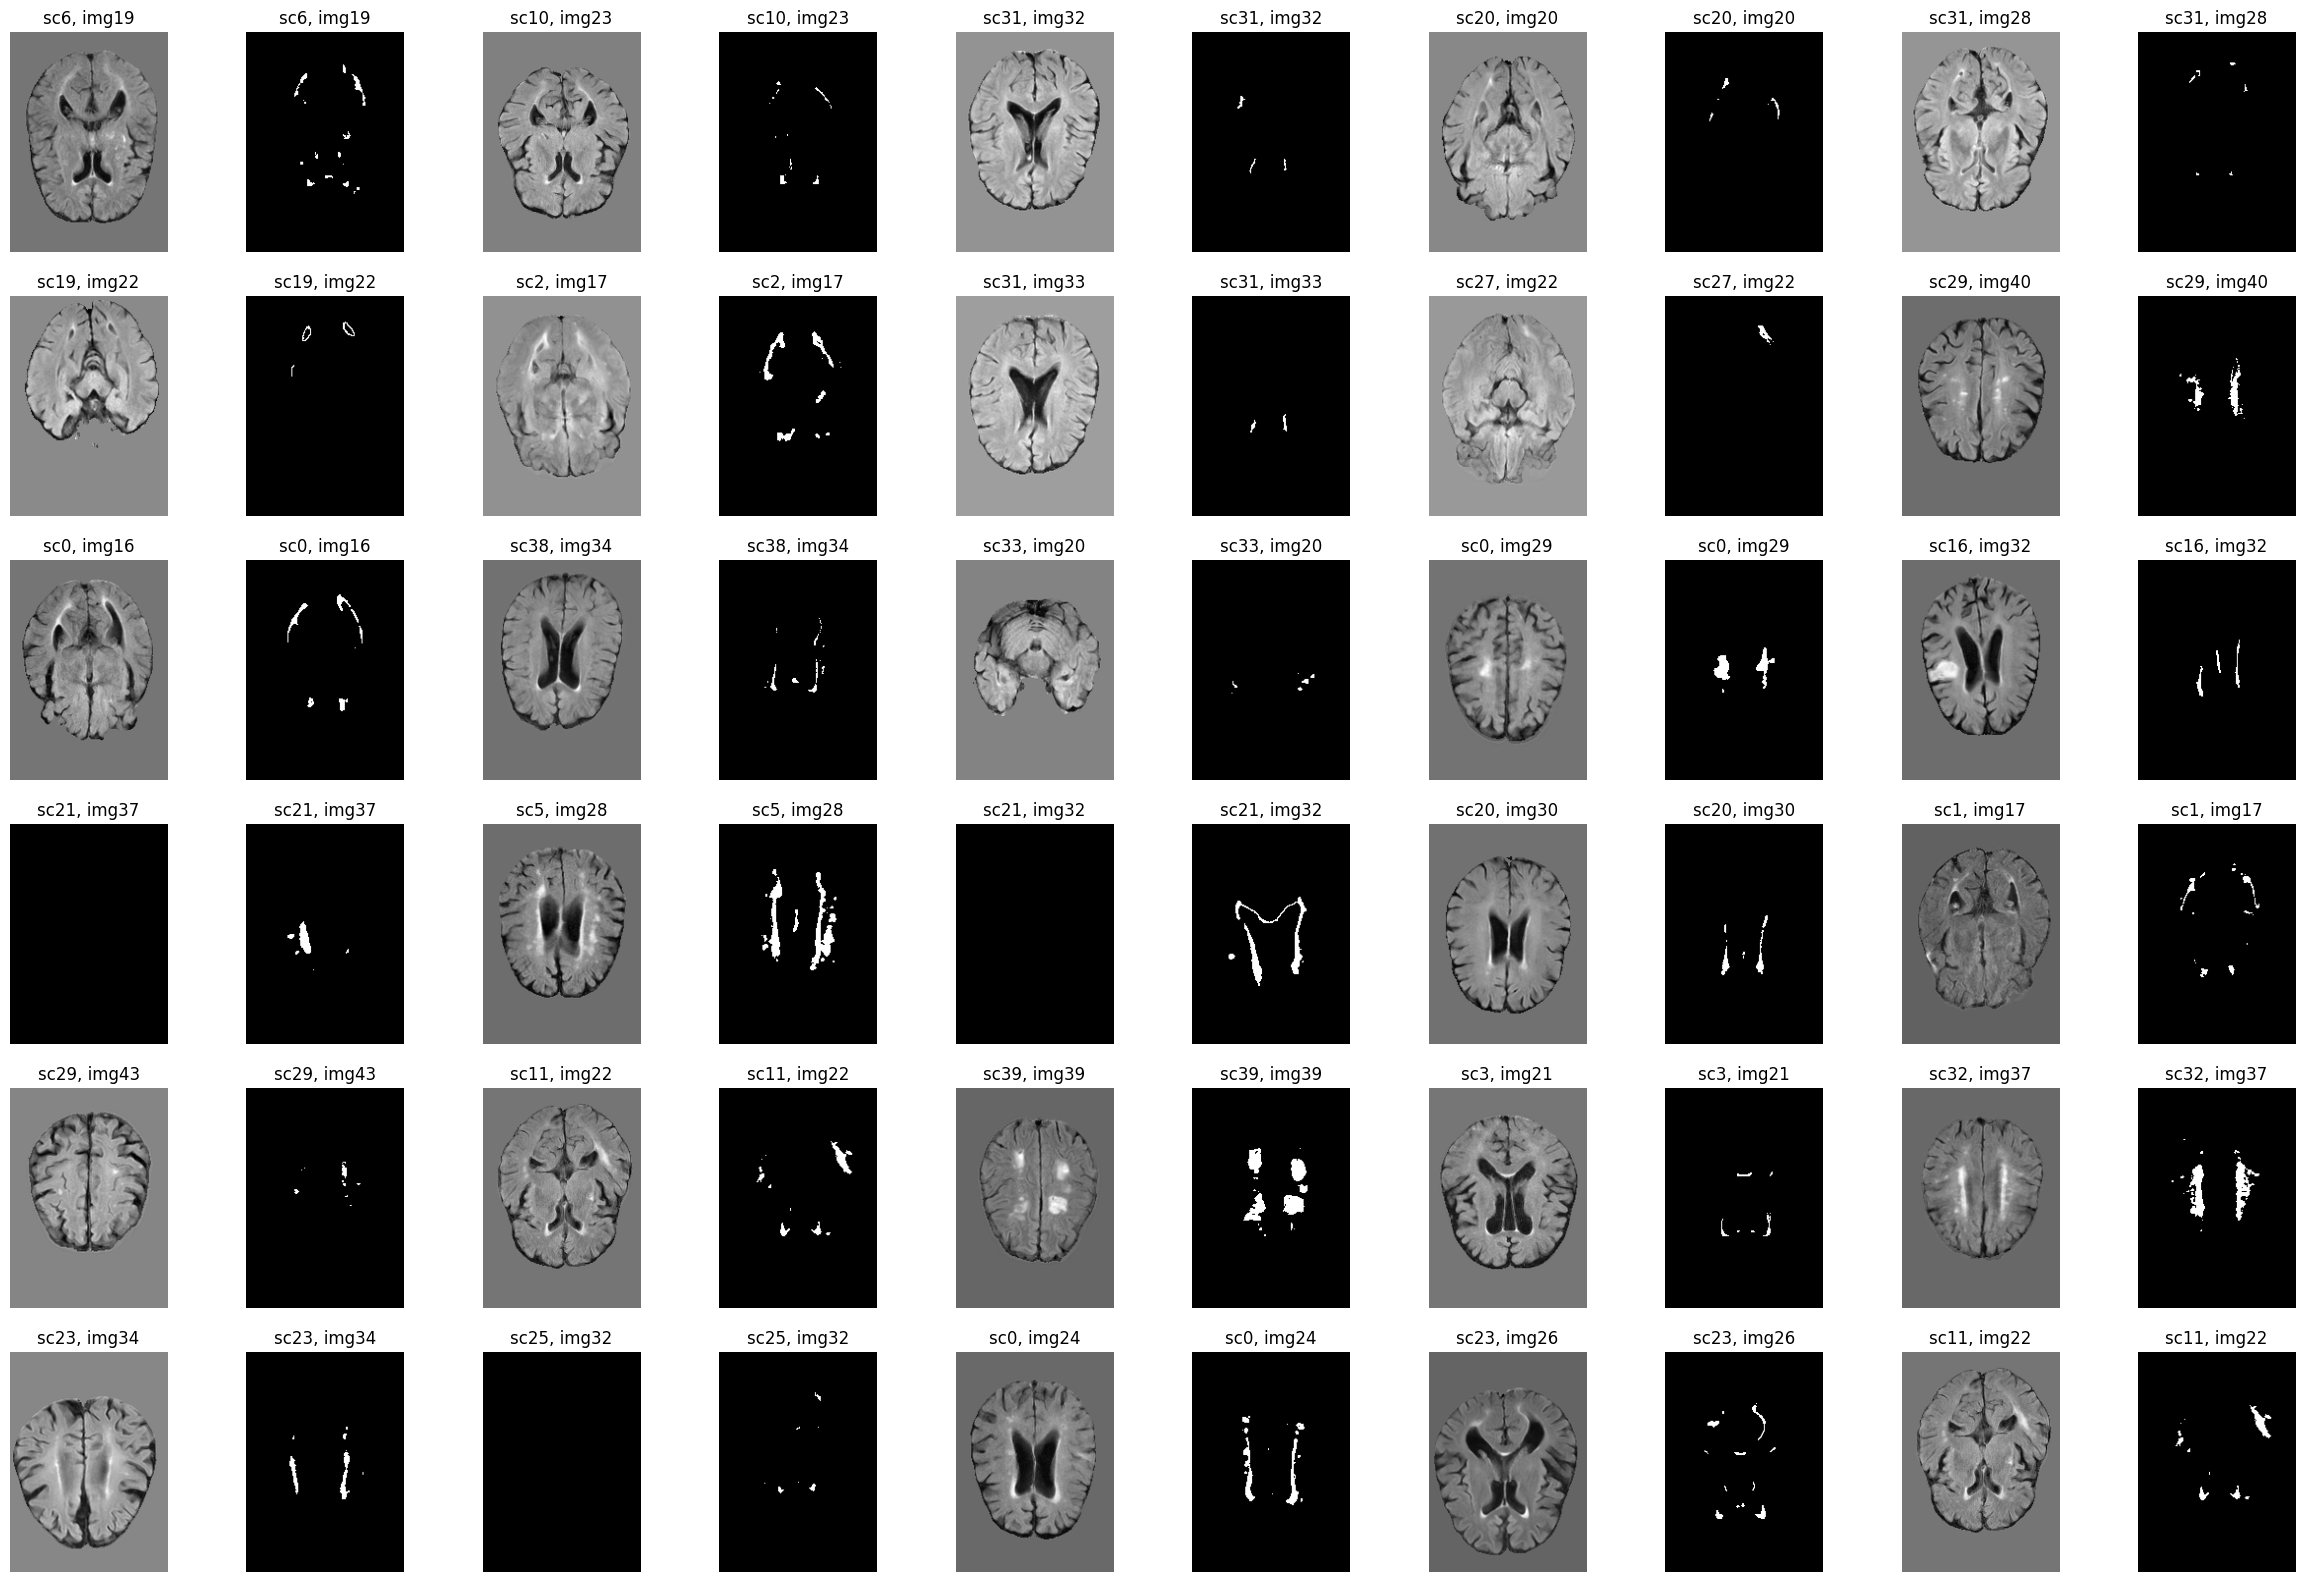

In [24]:
print_flair_and_target(ys3d_test, xs3d_test, slice_ids, sorted_burden_ids)

In [25]:
# print the target and the prediction
def print_target_and_prediction(ys3d, preds, slice_ids, sorted_burden_ids, folder_name, save=None, ood=False):
    plt.figure(figsize=(28,20))
    count = 0
    for i in range(3*10):
        slice_id = slice_ids[i]
        sc = sorted_burden_ids[slice_id,0]
        img = sorted_burden_ids[slice_id,1]

        plt.subplot(6, 10, count+1)
        plt.imshow(ys3d[sc][img], cmap='gray')
        plt.title(f"sc{sc}, img{img} GT")
        plt.axis('off')

        plt.subplot(6, 10, count+2)
        plt.imshow(preds[sc][img].argmax(dim=0), cmap='binary')
        plt.title(f"sc{sc}, img{img} Pred")
        plt.axis('off')
        count += 2
        
    if save:
        
        save(f"model_{'DOMAIN' if ood else ''}: {folder_name} target and pred")

### Running the whole loop

In [32]:
def run_loop(model_index, model):
    val_preds, test_preds = get_preds(model_index, model)
    
    # plot images
    #print_target_and_prediction(ys3d_test, test_preds, slice_ids, sorted_burden_ids, "results", save=None, ood=False)
    
    # run metrics
    chal_stats = per_model_chal_stats(test_preds, ys3d_test)
    #write_model_metric_results(model_name, chal_stats)
    
    # run calibration
    calib_stats = calibrate_model(ys3d_test, test_preds)
    #write_calibration_results(model_name, calib_stats)
    
    return val_preds, test_preds, chal_stats, calib_stats

In [33]:
models_chal_data = {}
models_calibration = {}
# models_domain_chal_data = {}
# models_domain_calibration = {}
models_val_preds = {}
models_test_preds = {}

for mi in range(len(model_names)):
    # run in domain
    val_preds, test_preds, chal_stats, calib_stats = run_loop(mi, model)
    models_chal_data[model_names[mi]] = chal_stats
    models_calibration[model_names[mi]] = calib_stats
    models_val_preds[model_names[mi]] = val_preds
    models_test_preds[model_names[mi]] = test_preds
    
    # # run out domain
    # chal_stats, calib_stats = run_loop(model, chal_xs3d, chal_ys3d, model_name, ood=True)
    # models_domain_chal_data[model_name] = chal_stats
    # models_domain_calibration[model_name] = calib_stats
    
    #print_and_write("OUT OF DISTRIBUTION RESULTS BELOW")

deterministic_dice_split0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:04<00:00, 10.46it/s]


deterministic_tversky_split0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:03<00:00, 11.21it/s]


deterministic_xent_split0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:03<00:00, 11.41it/s]


deterministic_dice+xent_split0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:03<00:00, 10.97it/s]


deterministic_brier_split0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:03<00:00, 11.53it/s]


deterministic_tversky07_split0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:03<00:00, 11.75it/s]


deterministic_tversky09_split0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:03<00:00, 11.42it/s]


In [34]:
models_chal_data['deterministic_dice_split0']['dice']

tensor([0.7910, 0.7196, 0.7501, 0.6285, 0.8571, 0.8368, 0.6228, 0.7336, 0.6051,
        0.8579, 0.7135, 0.8519, 0.5686, 0.7541, 0.7502, 0.5538, 0.7534, 0.6732,
        0.7942, 0.5142, 0.8079, 0.0000, 0.8920, 0.7768, 0.6299, 0.0136, 0.5630,
        0.6403, 0.2579, 0.7575, 0.6753, 0.5991, 0.7973, 0.8662, 0.4309, 0.5447,
        0.6486, 0.7798, 0.5830, 0.8376, 0.7042, 0.5767])

In [35]:
models_chal_data['deterministic_xent_split0']['dice']

tensor([0.7699, 0.7795, 0.7664, 0.6587, 0.8705, 0.8411, 0.6491, 0.6794, 0.5962,
        0.8646, 0.7185, 0.8616, 0.6207, 0.7745, 0.7624, 0.4597, 0.7052, 0.7307,
        0.7838, 0.4395, 0.7731, 0.6182, 0.8972, 0.7643, 0.6088, 0.1922, 0.6151,
        0.6304, 0.5592, 0.7525, 0.6777, 0.4186, 0.8109, 0.8778, 0.4623, 0.5547,
        0.6828, 0.7911, 0.5635, 0.8326, 0.6923, 0.5641])

### Examining our results and saving the plots!

In [36]:
model_names

['deterministic_dice_split0',
 'deterministic_tversky_split0',
 'deterministic_xent_split0',
 'deterministic_dice+xent_split0',
 'deterministic_brier_split0',
 'deterministic_tversky07_split0',
 'deterministic_tversky09_split0']

In [37]:
def save_result_plot(fname, show=True):
    pass
    # plot_root = "./inplace_plots/"
    # plt.tight_layout()
    # plt.savefig(plot_root + fname, bbox_inches = "tight")
    # if show:
    #     plt.show()
    # plt.clf()
    # plt.close()

In [38]:
import pandas as pd

In [39]:
plt.style.use('fivethirtyeight')

In [55]:
plotting_names = {
    'deterministic_tversky09_split0':'Tversky \nB=0.9',
    'deterministic_tversky07_split0':'Tversky \nB=0.7',
    'deterministic_xent_split0':'Cross\nEntropy',
    'deterministic_brier_split0':'Brier',
    'deterministic_dice_split0':'Dice',
    #'deterministic_tversky_split0': 'Tversky \nB=0.7 2',
    'deterministic_dice+xent_split0': 'Combo'
}

plotting_names_inverse = {value:key for (key, value) in plotting_names.items()}

In [41]:
dfs = []
for method in models_chal_data.keys():
    df = pd.DataFrame(models_chal_data[method])
    if method in plotting_names:
        abrv_name = plotting_names[method]
        # adds a column that just puts in the models name
        df["Loss Function"] = np.array([abrv_name for i in range(len(models_chal_data[method]['dice']))])
        dfs.append(df)
    else:
        print(f"no plotting name for {method}, it will be excluded")
    
    

no plotting name for deterministic_tversky_split0, it will be excluded


In [42]:
alldf = pd.concat(dfs)

In [53]:
loss_column_map = {"dice":"Dice Similarity Coefficient", "hd95":"HD95 (mm)", "avd":"Absolute Volume Difference (%)", "recall":"Lesion Recall", "f1":"Lesion F1"}
loss_column_inverse_map = {value:key for (key, value) in loss_column_map.items()}

plotdf = alldf.rename(columns=loss_column_map)

In [44]:
plotdf

,Dice Similarity Coefficient,HD95 (mm),Absolute Volume Difference (%),Lesion Recall,Lesion F1,Loss Function
0,0.790992,2.449490,11.763371,0.666667,0.403101,Dice
1,0.719570,6.082763,18.023888,0.450000,0.514286,Dice
2,0.750100,3.464102,19.334602,0.527027,0.634146,Dice
3,0.628478,8.544003,19.705143,0.750000,0.467532,Dice
4,0.857071,1.732051,12.658066,0.566667,0.604200,Dice
...,...,...,...,...,...,...
37,0.648025,3.741657,98.693222,0.581081,0.316409,Tversky \nB=0.9
38,0.506497,23.415798,97.261238,0.475000,0.356808,Tversky \nB=0.9
39,0.764519,3.162278,47.307487,0.888889,0.505263,Tversky \nB=0.9
40,0.581070,7.681146,104.765884,0.879310,0.572722,Tversky \nB=0.9


In [45]:
list(plotdf.keys())

['Dice Similarity Coefficient',
 'HD95 (mm)',
 'Absolute Volume Difference (%)',
 'Lesion Recall',
 'Lesion F1',
 'Loss Function']

In [46]:
loss_ordering = ['Brier', 'Cross\nEntropy', 'Combo', 'Dice', 'Tversky \nB=0.7', 'Tversky \nB=0.9']

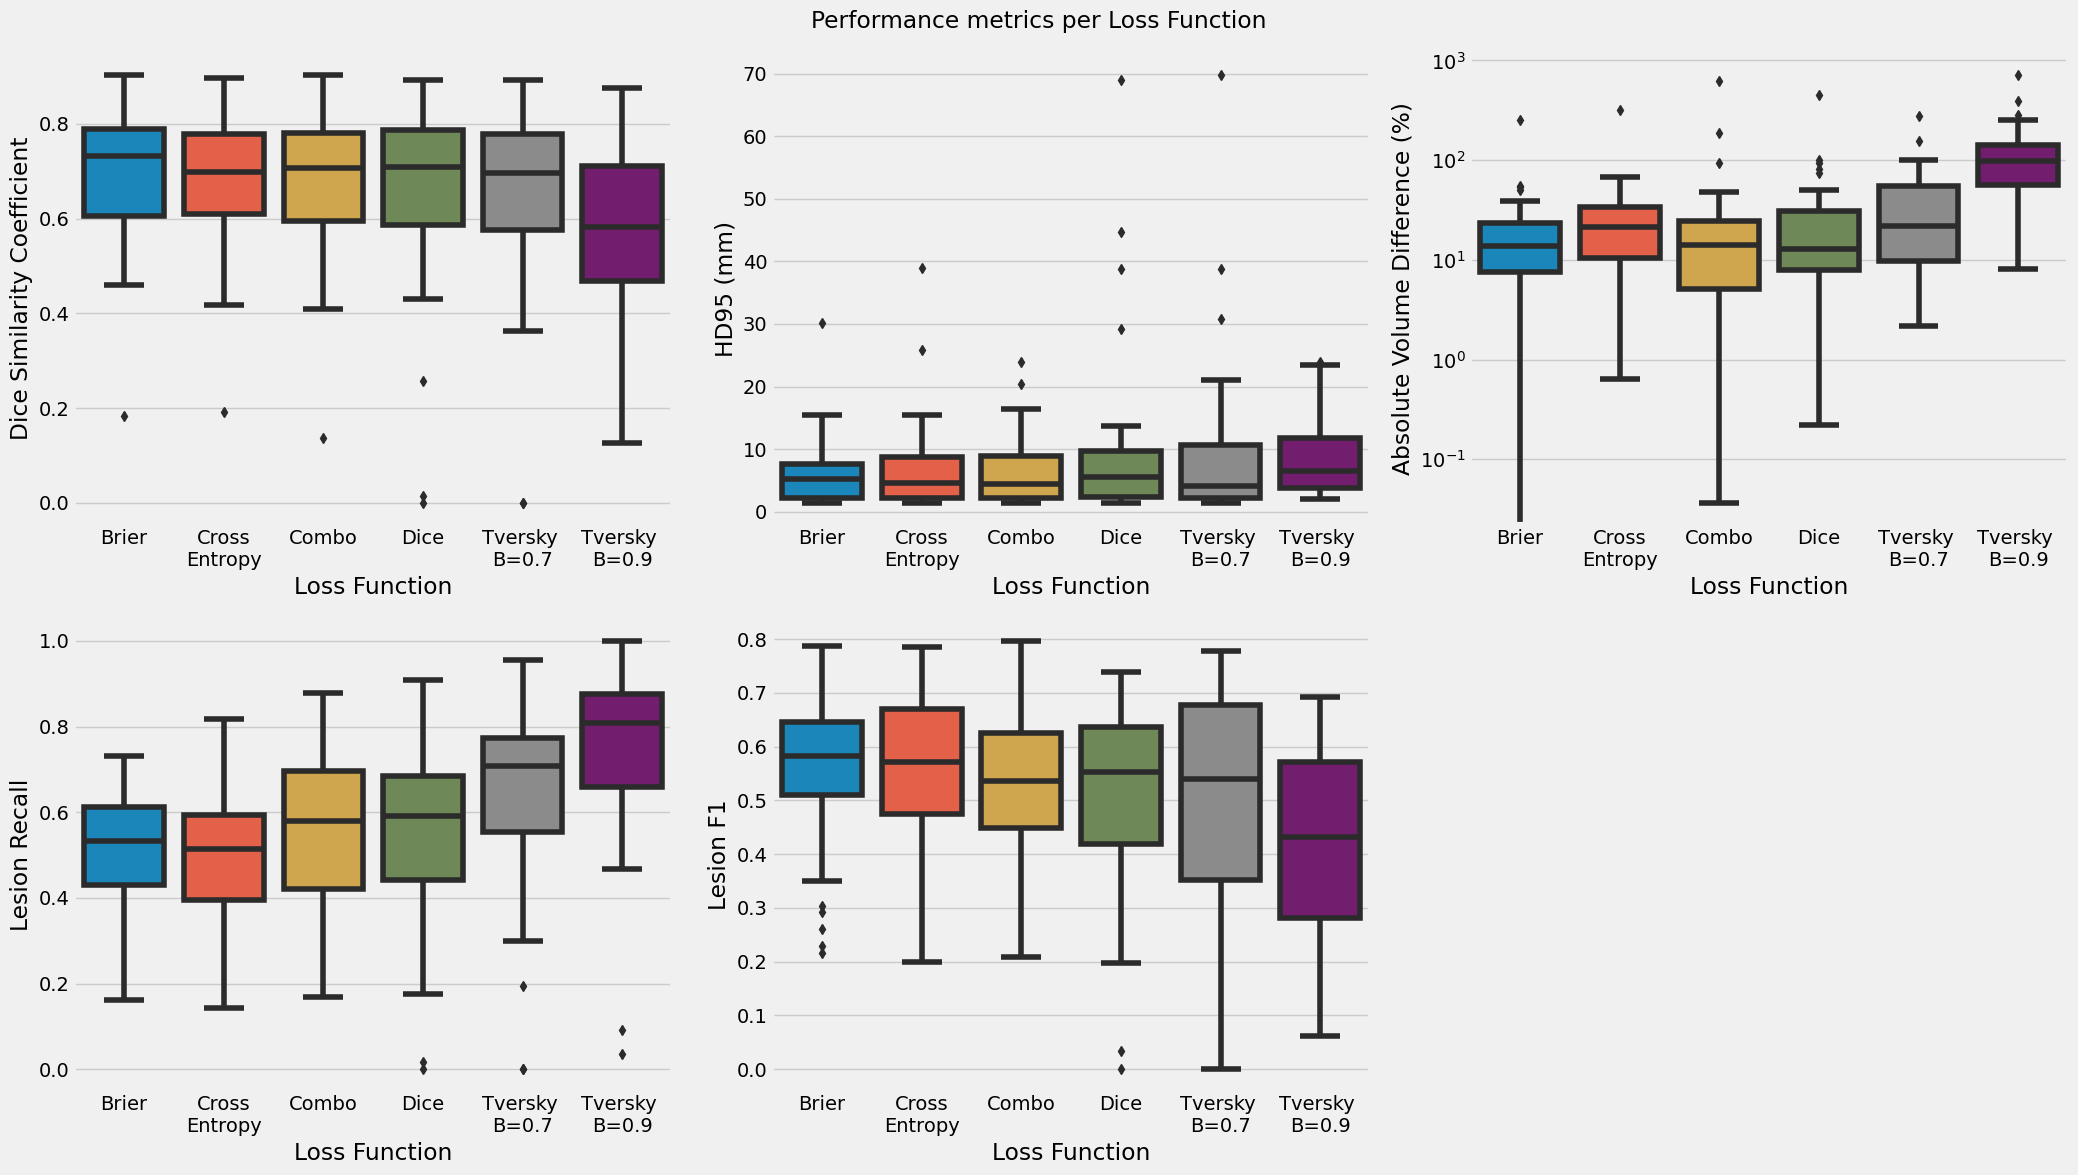

In [48]:
plt.figure(figsize=(7*3,6*2))

for i, metric in enumerate(plotdf.keys()):
    if metric == 'Loss Function':
        continue
    plt.subplot(2,3,i+1)
    sns.boxplot(data=plotdf, x="Loss Function", y=metric, order=loss_ordering)
    if metric == "Absolute Volume Difference (%)":
        plt.yscale('log')
    # plt.xticks(rotation = 45);
    
plt.suptitle("Performance metrics per Loss Function");
save("deterministic_results", "metrics_per_loss")

### Now examine Calibration

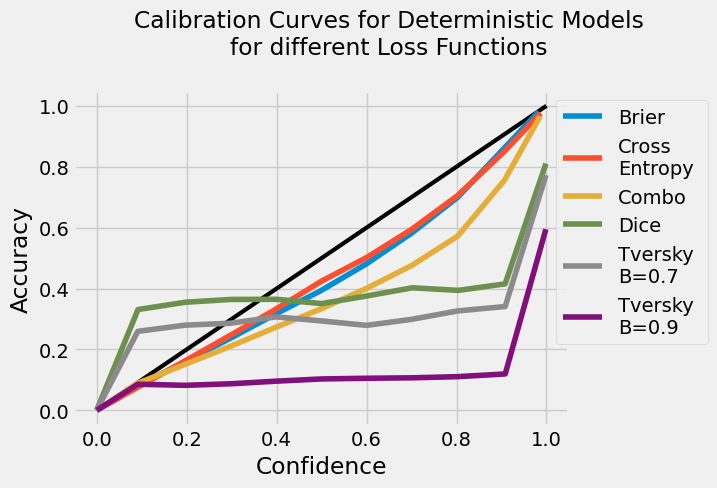

In [57]:
plt.figure(figsize=(8,5))
plt.plot([0,1],[0,1], c='black', linewidth=3);

for method in loss_ordering:
    method_raw_name = plotting_names_inverse[method]
    plt.plot(models_calibration[method_raw_name]['bin_confidences'], models_calibration[method_raw_name]['bin_accuracies'], linewidth=4, label=method)

plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.xlabel("Confidence")
plt.ylabel("Accuracy");
plt.suptitle("Calibration Curves for Deterministic Models\nfor different Loss Functions")
save("deterministic_results", "calibration_per_loss")

In [58]:
for method in models_calibration.keys():
    print(f"method: {method}, ece: {models_calibration[method]['ece']}")

method: deterministic_dice_split0, ece: 0.19709458947181702
method: deterministic_tversky_split0, ece: 0.5235986709594727
method: deterministic_xent_split0, ece: 0.03928937390446663
method: deterministic_dice+xent_split0, ece: 0.07737492024898529
method: deterministic_brier_split0, ece: 0.040404342114925385
method: deterministic_tversky07_split0, ece: 0.232199564576149
method: deterministic_tversky09_split0, ece: 0.4017312526702881


### Examining per individual calibration

In [59]:
def calibrate_model_individual(ys3d, preds3d):
    ind_results = []
    for batch_idx in tqdm(range(len(ys3d)), ncols=150, position=0, leave=True): # skip the last batch with a different shape
        # assess bin counts of p y = 1
        bins = 10 + 1 # for the 0 bin
        bin_batch_accuracies = [[] for b in range(bins)]
        bin_batch_confidences = [[] for b in range(bins)]
        bin_batch_sizes = [[] for b in range(bins)]
        bin_counts = [0 for b in range(bins)]

        batch_t = ys3d[batch_idx].squeeze()
        preds = preds3d[batch_idx]

        if batch_t.shape[0] < 10:
            continue # skip last batch if it is very small.

        # get probabilities
        p1s = preds[:,1]

        # split into bins
        bin_ids = place_in_bin(p1s)

        # compute counts
        for i in range(bins):
            is_in_bin = (bin_ids == (i / 10))
            # print(is_in_bin.shape)
            # print(batch_t.shape)

            # number of elements in each bin
            num_elem = torch.sum(is_in_bin).item()
            # if num_elem == 0:
            #     print("zero")

            # number of predictions = to class 1
            c1_acc = batch_t[is_in_bin].sum() / num_elem

            # if torch.isnan(c1_acc):
            #     print("acc_nan")

            # average confidence of values in that bin
            c1_conf = p1s[is_in_bin].mean()

            # if torch.isnan(c1_conf):
            #     print("conf_nan")

            bin_batch_accuracies[i].append(c1_acc)
            bin_batch_confidences[i].append(c1_conf)
            bin_batch_sizes[i].append(num_elem)

        # compute overall calibration bins
        bin_sizes = [torch.Tensor(bbs).sum() for bbs in bin_batch_sizes]
        bin_accuracies = [torch.Tensor([bin_batch_accuracies[i][j] * bin_batch_sizes[i][j] / bin_sizes[i] for j in range(len(bin_batch_accuracies[i]))]).sum().item() for i in range(len(bin_sizes))]
        bin_confidences = [torch.Tensor([bin_batch_confidences[i][j] * bin_batch_sizes[i][j] / bin_sizes[i] for j in range(len(bin_batch_confidences[i]))]).sum().item() for i in range(len(bin_sizes))]

        # compute ece
        total_size = torch.sum(torch.Tensor(bin_sizes)[1:])
        ece = torch.sum( (torch.Tensor(bin_sizes)[1:]/ total_size) * (torch.abs(torch.Tensor(bin_accuracies)[1:] - torch.Tensor(bin_confidences)[1:])))
    
    
        ind_results.append({"bin_confidences":bin_confidences, 
                "bin_accuracies":bin_accuracies,
                "ece":ece,
               })
        
    return ind_results

In [62]:
models_ind_calibration = {}

for mid in range(len(model_names)):
    test_preds = models_test_preds[model_names[mid]]
    
    # run calibration
    ind_calib_stats = calibrate_model_individual(ys3d_test, test_preds)
            
    models_ind_calibration[model_names[mid]] = ind_calib_stats

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:03<00:00, 10.93it/s]


In [271]:
models_ind_calibration.keys()

dict_keys(['deterministic_dice_split0', 'deterministic_tversky_split0', 'deterministic_xent_split0', 'deterministic_dice+xent_split0', 'deterministic_brier_split0', 'deterministic_tversky07_split0', 'deterministic_tversky09_split0'])

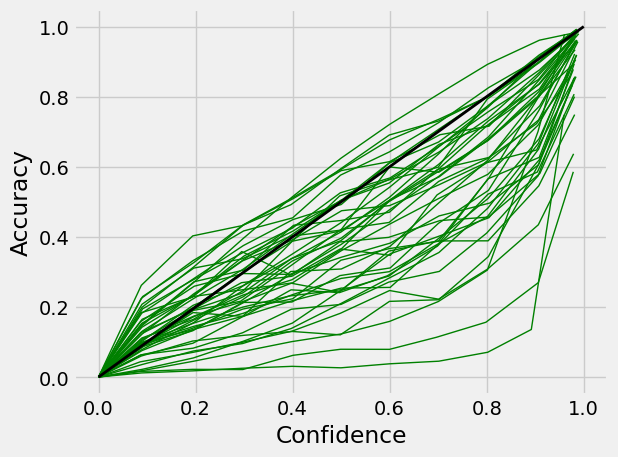

In [64]:
c_data = models_ind_calibration['deterministic_dice+xent_split0']
for d in c_data:
    plt.plot(d['bin_confidences'], d['bin_accuracies'], linewidth=1, c='green')
plt.plot([0,1], [0,1], linewidth=2, c='black')
plt.xlabel("Confidence")
plt.ylabel("Accuracy");
save("deterministic_results", "Calib_combo_loss_per_ind")

In [91]:
# now doing the mean per individual
individual_bin_confs = [[] for _ in range(10+1)]
individual_bin_accs = [[] for _ in range(10+1)]

for data_dict in models_ind_calibration['deterministic_dice+xent_split0']:
    #print(len(data_dict['bin_confidences']))
    for i, value in enumerate(data_dict['bin_confidences']):
        individual_bin_confs[i].append(value)
    for i, value in enumerate(data_dict['bin_accuracies']):
        individual_bin_accs[i].append(value)


In [93]:
individual_bin_confs = [torch.Tensor(ibc) for ibc in individual_bin_confs]
individual_bin_accs = [torch.Tensor(iba) for iba in individual_bin_accs]

In [96]:
averaged_bin_confs = [v.mean() for v in individual_bin_confs]
averaged_bin_accs = [v.mean() for v in individual_bin_accs]

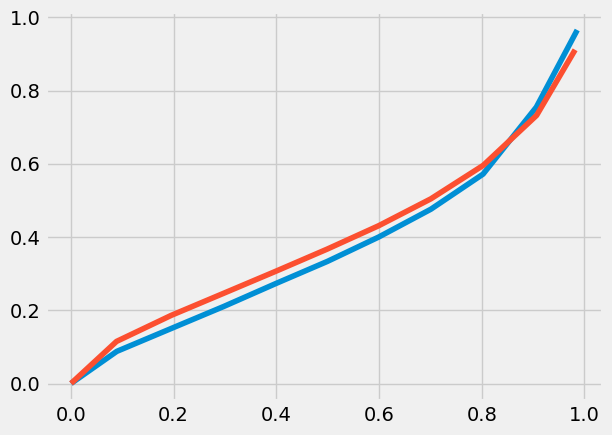

In [99]:
plt.plot(models_calibration['deterministic_dice+xent_split0']['bin_confidences'], models_calibration['deterministic_dice+xent_split0']['bin_accuracies'], linewidth=4, label=method)
plt.plot(averaged_bin_confs, averaged_bin_accs)

In [73]:
import scipy.stats
import math

In [74]:
vols = []
log_vols = []
eces = []
for i in range(len(ys3d_test)):
    wmh_vol = ys3d_test[i].sum().item() * 0.003
    ece = models_ind_calibration['deterministic_dice+xent_split0'][i]['ece']
    log_vols.append(math.log(wmh_vol))
    vols.append(wmh_vol)
    eces.append(ece)
    
    

In [77]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(log_vols, eces)

In [78]:
slope, intercept, r_value, p_value, std_err

(-0.03588521990326799,
 0.19161021442400306,
 -0.5805643092196879,
 5.564693366796642e-05,
 0.007957452584540324)

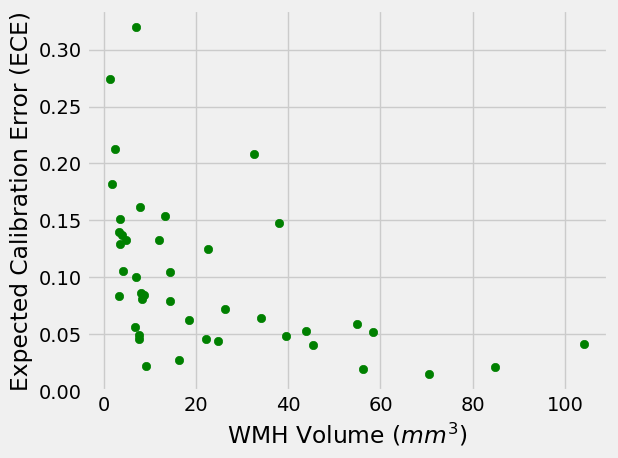

In [82]:
plt.scatter(vols, eces, c='green')
plt.ylabel("Expected Calibration Error (ECE)")
plt.xlabel(r"WMH Volume ($mm^3$)")
#plt.xscale('log')
save("deterministic_results", "volume_vs_combo_loss_ece")

In [67]:
models_ind_calibration['deterministic_dice+xent_split0'][0]['ece']

tensor(0.0721)

In [277]:
models_val_preds.keys()

dict_keys(['deterministic_dice_split0', 'deterministic_tversky_split0', 'deterministic_xent_split0', 'deterministic_dice+xent_split0', 'deterministic_brier_split0', 'deterministic_tversky07_split0', 'deterministic_tversky09_split0'])

In [166]:
# try temperature scaling:
models_ind_calibration_tscale = {}

for fid in range(len(folders)):
    model = load_model(fid)
    model_name = folders[fid]
    if "haus" in model_name:
        continue # hausdorff loss is broken :(
    # print(model_name)
    
    if "dice" not in model_name and "xent_mean_sum_none" not in model_name:
        continue
            
    # run in domain
    t = 1.5
    preds = get_preds(model, xs3d_ed, temp=t)
    ind_calib_stats_tscale = calibrate_model(ys3d_ed, preds)
    models_ind_calibration_tscale[model_name] = ind_calib_stats_tscale

checkpoint:  /home/s2208943/ipdis/results/revamped_models/deterministic_hausdorff/epoch=27-step=4116.ckpt
checkpoint:  /home/s2208943/ipdis/results/revamped_models/deterministic_tversky09/epoch=38-step=5733.ckpt
checkpoint:  /home/s2208943/ipdis/results/revamped_models/deterministic_tversky07/epoch=38-step=5733.ckpt
checkpoint:  /home/s2208943/ipdis/results/revamped_models/deterministic_xent_mean_sum_none/epoch=16-step=2499.ckpt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:02<00:00, 15.48it/s]


checkpoint:  /home/s2208943/ipdis/results/revamped_models/deterministic_xent_mean_sum_bigweight/epoch=10-step=1617.ckpt
checkpoint:  /home/s2208943/ipdis/results/revamped_models/deterministic_brier_mean_sum/epoch=39-step=5880.ckpt
checkpoint:  /home/s2208943/ipdis/results/revamped_models/deterministic_avd/epoch=32-step=4851.ckpt
checkpoint:  /home/s2208943/ipdis/results/revamped_models/deterministic_brier_mean/epoch=14-step=2205.ckpt
checkpoint:  /home/s2208943/ipdis/results/revamped_models/deterministic_dice/epoch=37-step=5586.ckpt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:02<00:00, 15.79it/s]


checkpoint:  /home/s2208943/ipdis/results/revamped_models/deterministic_xent_mean/epoch=15-step=2352.ckpt
checkpoint:  /home/s2208943/ipdis/results/revamped_models/deterministic_xent_mean_sum/epoch=14-step=2205.ckpt
checkpoint:  /home/s2208943/ipdis/results/revamped_models/deterministic_brier_sum/epoch=24-step=3675.ckpt
checkpoint:  /home/s2208943/ipdis/results/revamped_models/deterministic_xent_sum/epoch=3-step=588.ckpt
checkpoint:  /home/s2208943/ipdis/results/revamped_models/deterministic_xent_mean_sum_inverse/epoch=14-step=2205.ckpt


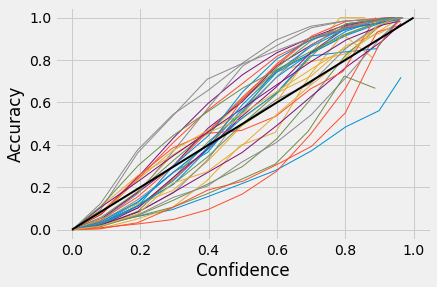

In [167]:
c_data = models_ind_calibration_tscale['deterministic_xent_mean_sum_none']
for d in c_data:
    plt.plot(d['bin_confidences'], d['bin_accuracies'], linewidth=1)
plt.plot([0,1], [0,1], linewidth=2, c='black')
plt.xlabel("Confidence")
plt.ylabel("Accuracy");

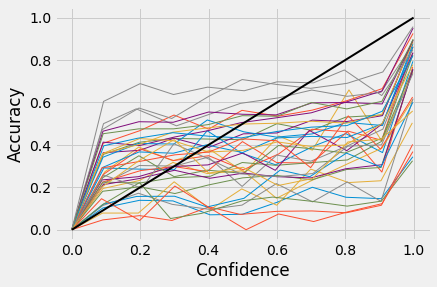

In [168]:
c_data = models_ind_calibration_tscale['deterministic_dice']
for d in c_data:
    plt.plot(d['bin_confidences'], d['bin_accuracies'], linewidth=1)
plt.plot([0,1], [0,1], linewidth=2, c='black')
plt.xlabel("Confidence")
plt.ylabel("Accuracy");

### WMH volume vs metrics standard analysis

In [42]:
data = per_model_chal_stats(preds, ys3d_ed)

100%|██████████████████████████████████████████████████████| 180/180 [04:12<00:00,  1.40s/it]


In [43]:
#data

In [44]:
# comptue the volumes per person.
# need to look at calibration per person.

In [45]:
volumes = []
for ys in ys3d_ed:
    volumes.append(ys.sum())

In [46]:
plt.style.use('fivethirtyeight')

In [47]:
def plot_data(data, xlog=False, ylog=False, color=None):
    plt.figure(figsize=(12, 8))
    for i, key in enumerate(data.keys()):
        plt.subplot(2,3,i+1)
        plt.scatter(volumes, data[key], c=color)
        plt.xlabel("WMH volume")
        plt.ylabel(key)
        if xlog:
            plt.xscale('log')
        if ylog:
            plt.yscale('log')
    plt.suptitle(f" {'Log ' if ylog else ''}Performance metrics vs {'Log ' if xlog else ''}of the WMH volume")

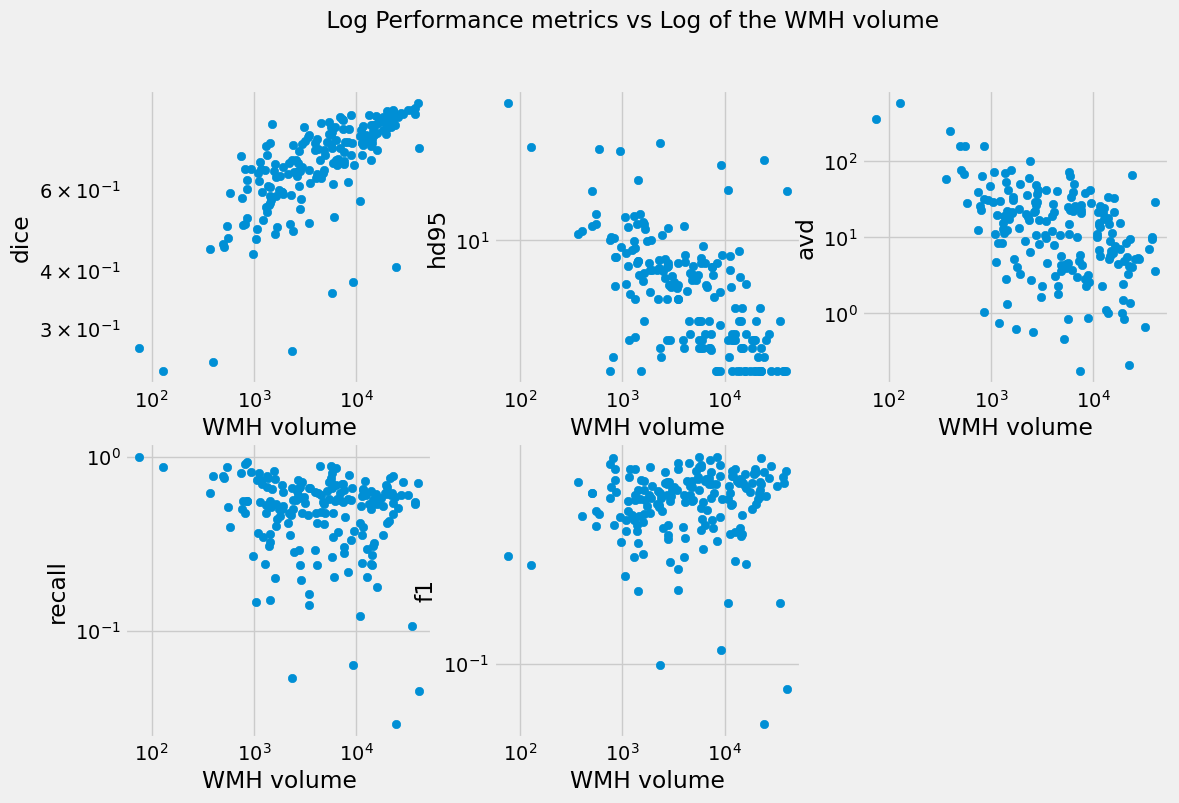

In [48]:
plot_data(data, xlog=True, ylog=True)

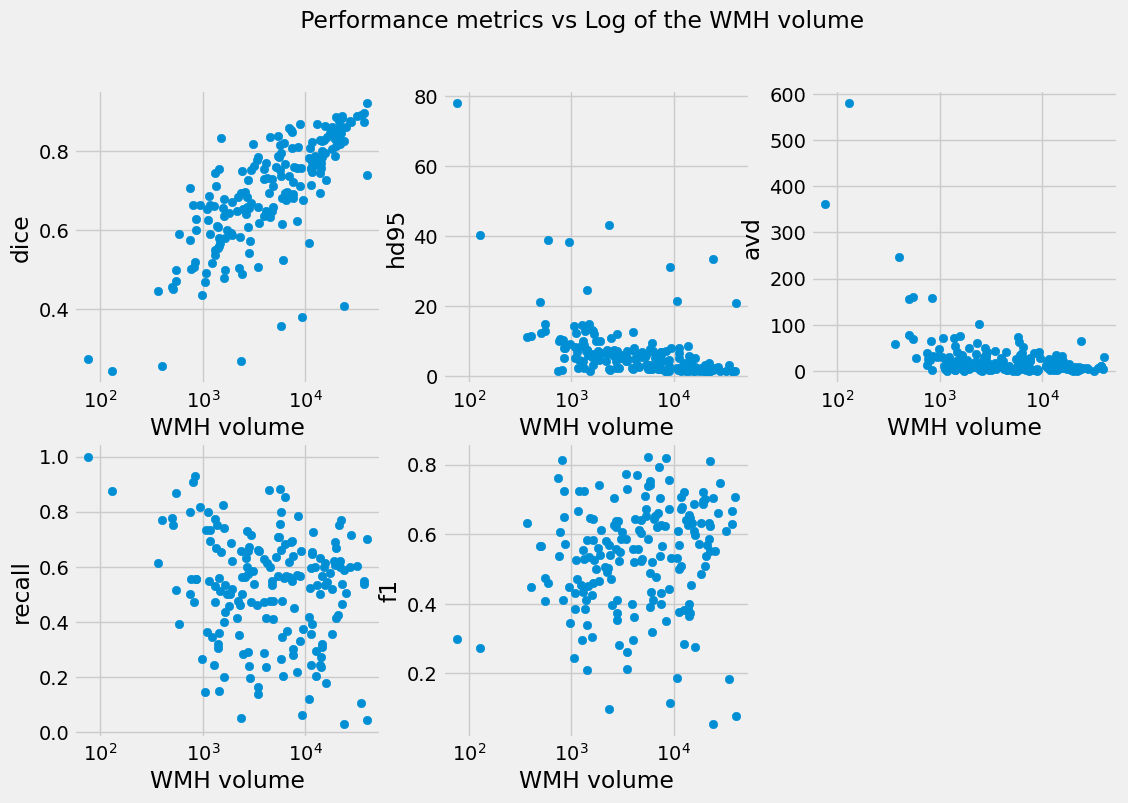

In [49]:
plot_data(data, xlog=True, ylog=False)

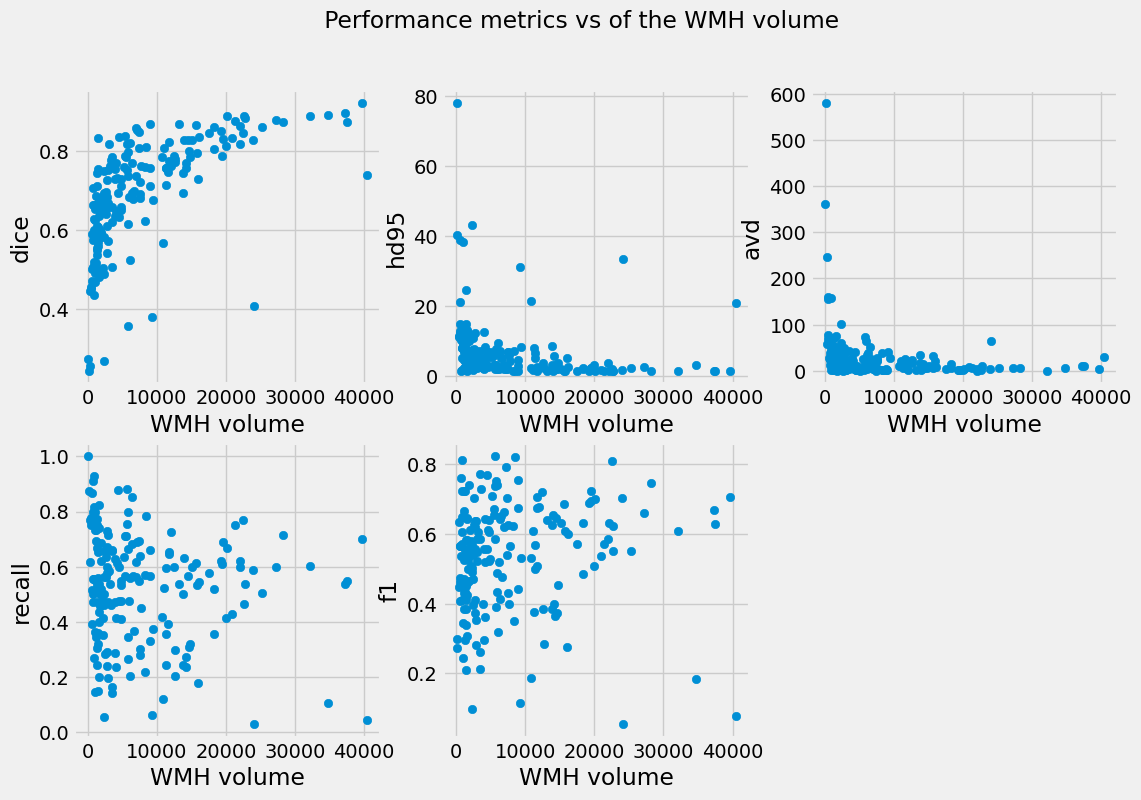

In [50]:
plot_data(data, xlog=False, ylog=False)

In [51]:
nlls = []
for i in range(len(ys3d_ed)):
    xent = torch.nn.functional.cross_entropy(preds[i], ys3d_ed[i].type(torch.long), reduction='none', weight=torch.Tensor([0.1, 0.97]))
    # print(xent.shape)
    nll = xent.sum(dim=(1,2)).mean()
    nll = xent.sum()
    nlls.append(nll)

In [52]:
preds[i].shape

torch.Size([56, 2, 224, 160])

Text(0, 0.5, 'NLL')

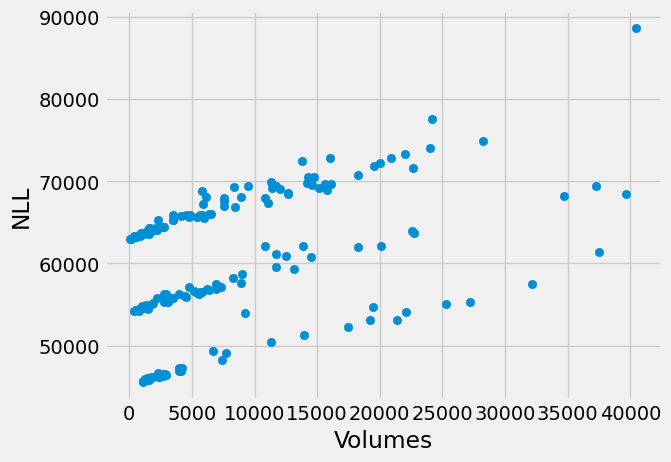

In [53]:
plt.scatter(volumes, nlls)
plt.xlabel('Volumes')
plt.ylabel('NLL')

In [96]:
### calculating edges
def get_edges(binary_img_batch):
    mins = torch.nn.functional.max_pool2d(1-binary_img_batch, kernel_size=3, padding=1, stride=1)
    # print(mins.shape)
    # print(binary_img_batch.shape)
    return (mins==1) * binary_img_batch

In [55]:
edge_ys = [get_edges(y) for y in ys3d_ed]
edge_preds = [get_edges(p.argmax(dim=1).type(torch.float32)).type(torch.long) for p in preds]

In [56]:
edge_ys[0].dtype

torch.float32

In [57]:
edge_data = per_model_chal_stats(edge_preds, edge_ys, False)

100%|██████████████████████████████████████████████████████| 180/180 [03:13<00:00,  1.08s/it]


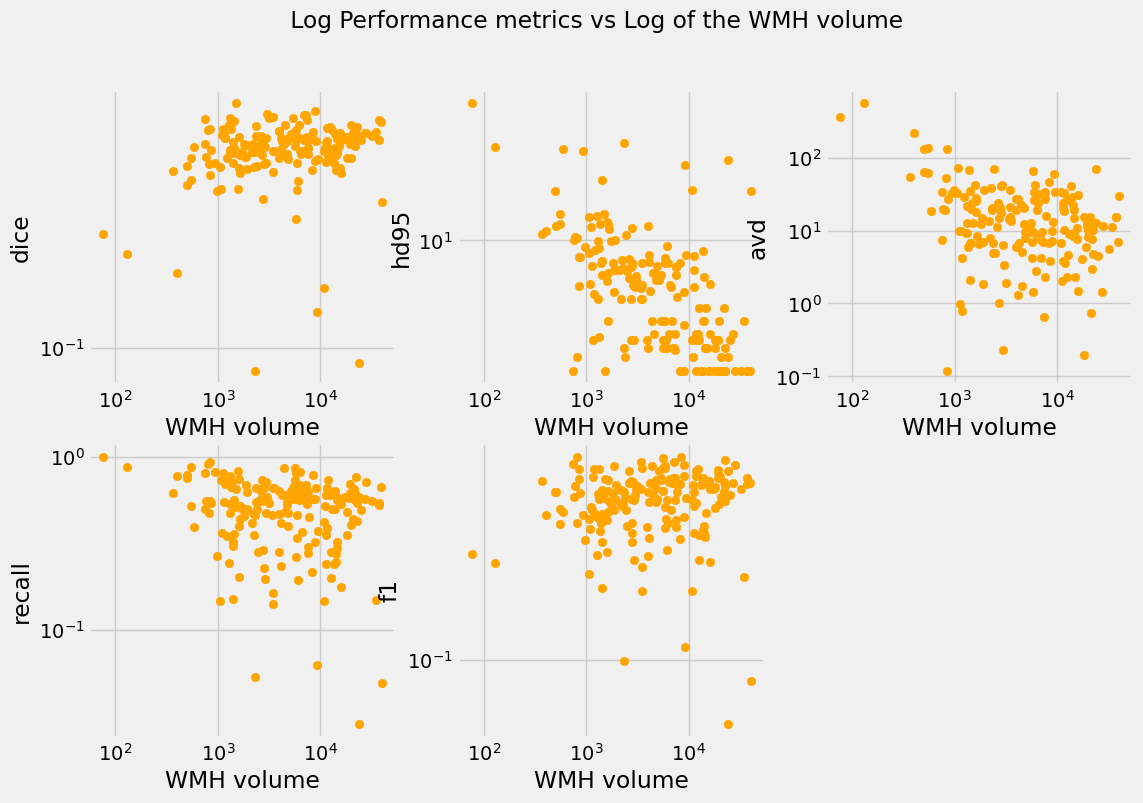

In [58]:
plot_data(edge_data, xlog=True, ylog=True, color='orange')

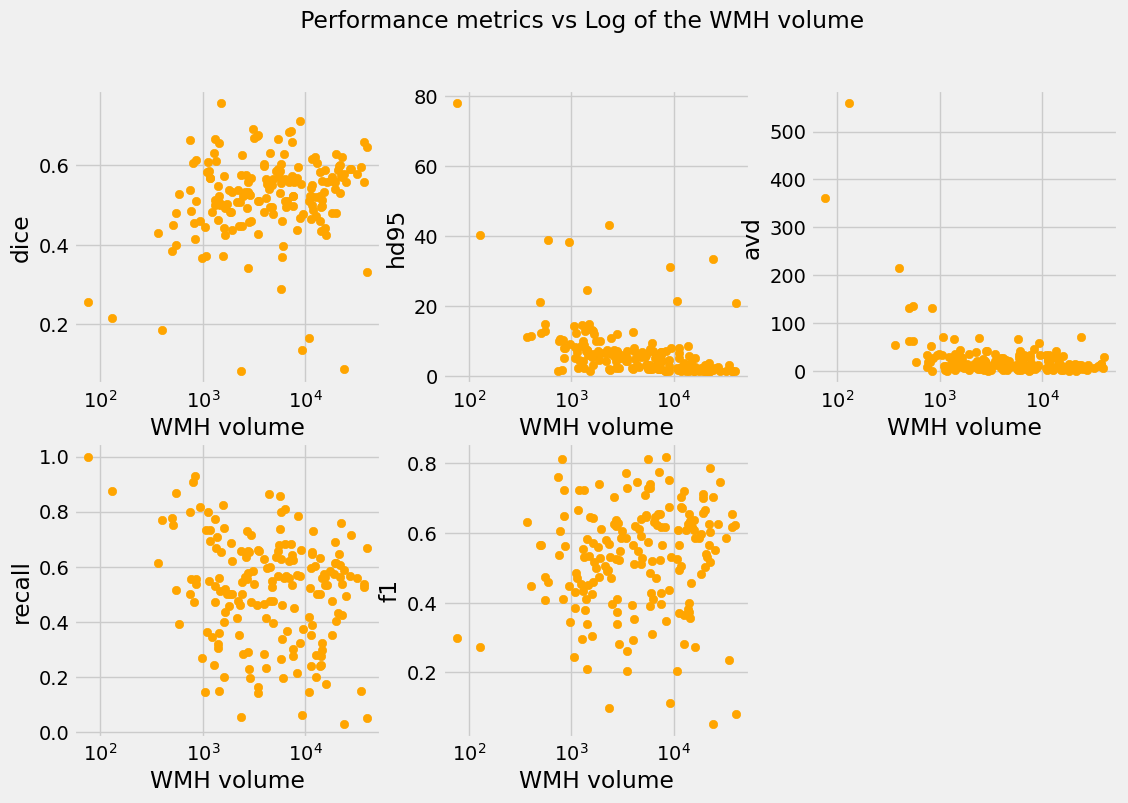

In [59]:
plot_data(edge_data, xlog=True, ylog=False, color='orange')

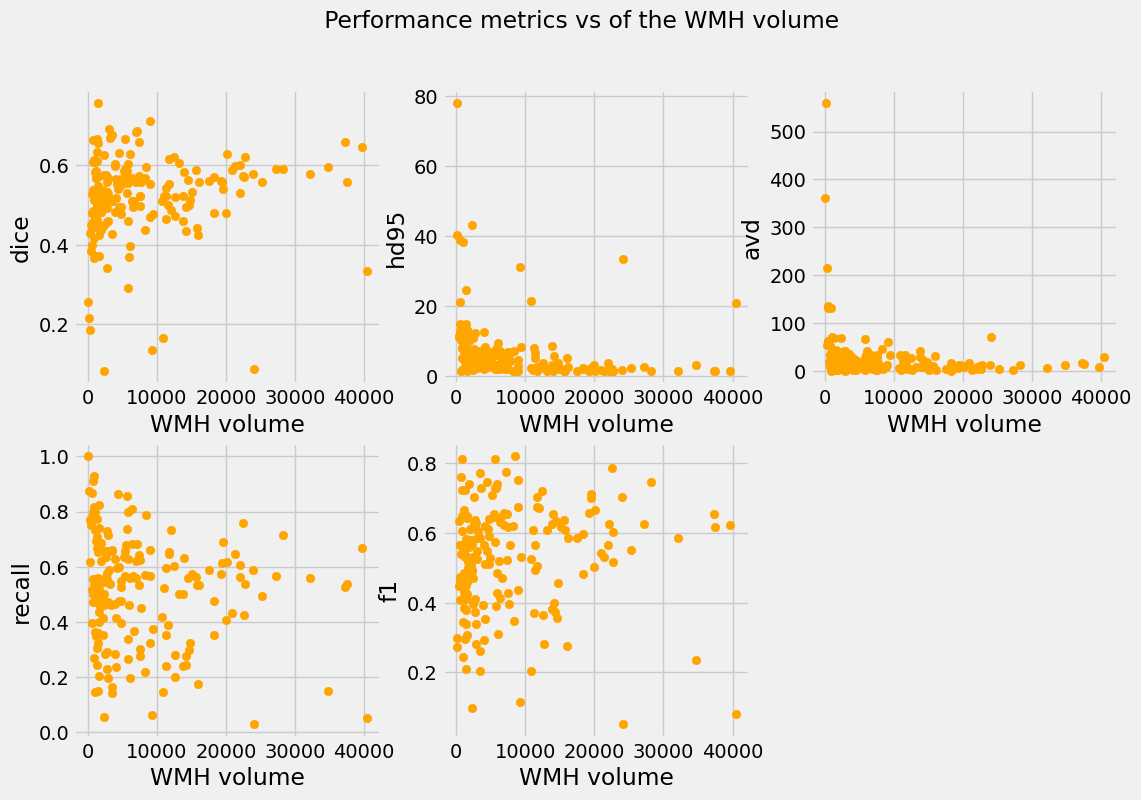

In [60]:
plot_data(edge_data, xlog=False, ylog=False, color='orange')

In [61]:
edge_volumes = []
for ys in edge_ys:
    edge_volumes.append(ys.sum())

Text(0, 0.5, 'WMH Edge to (total Volume) ratio')

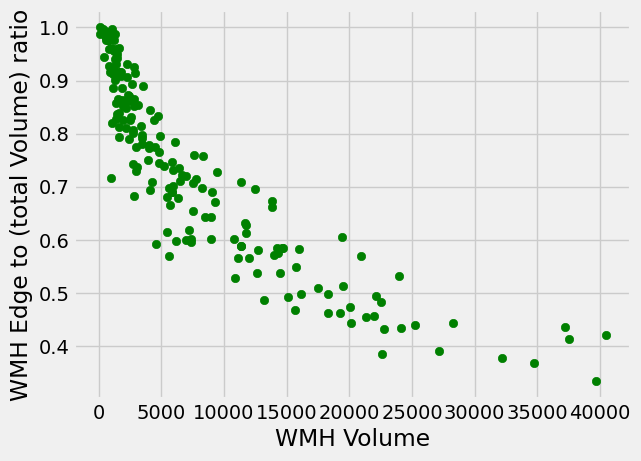

In [62]:
plt.scatter(volumes, [edge_volumes[i]/volumes[i] for i in range(len(volumes))], c='green')
plt.xlabel('WMH Volume')
plt.ylabel('WMH Edge to (total Volume) ratio')

In [63]:
scan_id = 26
slice_id = 30

Text(0.5, 1.0, 'Prediction Edge')

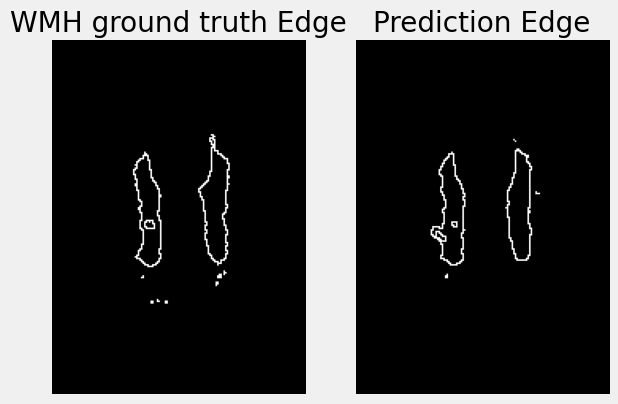

In [64]:
plt.subplot(1,2,1)
plt.imshow(edge_ys[scan_id][slice_id], cmap='gray'); plt.axis('off')
plt.title('WMH ground truth Edge')

plt.subplot(1,2,2)
plt.imshow(edge_preds[scan_id][slice_id], cmap='gray'); plt.axis('off')
plt.title('Prediction Edge')

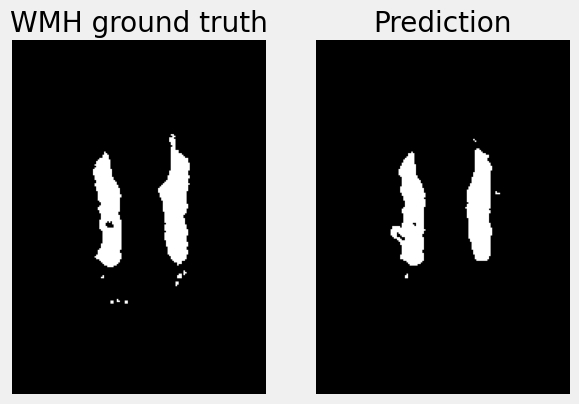

In [65]:
plt.subplot(1,2,1)
plt.imshow(ys3d_ed[scan_id][slice_id], cmap='gray'); plt.axis('off')
plt.title('WMH ground truth')

plt.subplot(1,2,2)
plt.imshow(preds[scan_id][slice_id].argmax(dim=0), cmap='gray'); plt.axis('off')
plt.title('Prediction');

### Skeletonise

In [66]:
from skimage.morphology import skeletonize, medial_axis, thin

In [67]:
method='lee'
gt_skeleton = skeletonize(ys3d_ed[scan_id][slice_id].numpy(), method=method)
pred_skeleton = skeletonize(preds[scan_id][slice_id].argmax(dim=0).numpy(), method=method)

/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/skimage/util/dtype.py:541: UserWarning: Downcasting int64 to uint8 without scaling because max value 1 fits in uint8
  return _convert(image, np.uint8, force_copy)


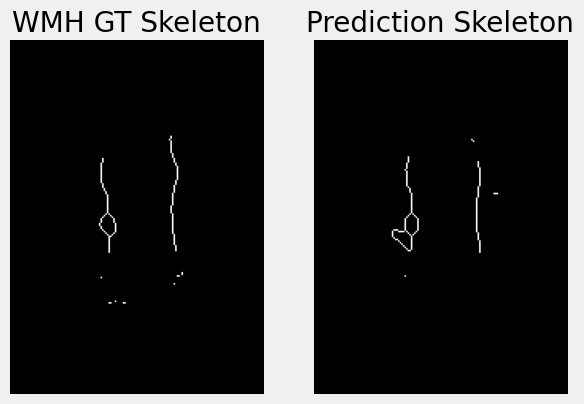

In [68]:
plt.subplot(1,2,1)
plt.imshow(gt_skeleton, cmap='gray'); plt.axis('off')
plt.title('WMH GT Skeleton')

plt.subplot(1,2,2)
plt.imshow(pred_skeleton, cmap='gray'); plt.axis('off')
plt.title('Prediction Skeleton');

In [69]:
gt_thin = thin(ys3d_ed[scan_id][slice_id].numpy())
pred_thin = thin(preds[scan_id][slice_id].argmax(dim=0).numpy())

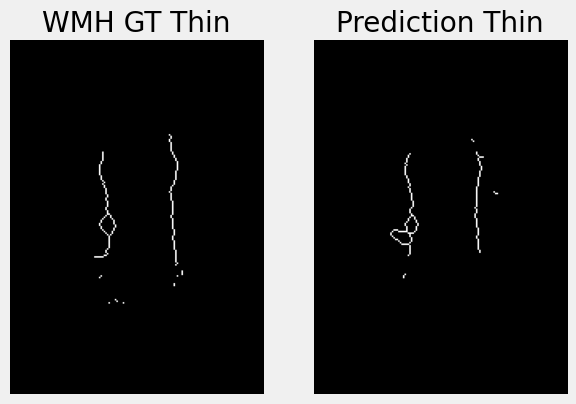

In [70]:
plt.subplot(1,2,1)
plt.imshow(gt_thin, cmap='gray'); plt.axis('off')
plt.title('WMH GT Thin')

plt.subplot(1,2,2)
plt.imshow(pred_thin, cmap='gray'); plt.axis('off')
plt.title('Prediction Thin');

In [71]:
gt_medial = medial_axis(ys3d_ed[scan_id][slice_id].numpy())
pred_medial = medial_axis(preds[scan_id][slice_id].argmax(dim=0).numpy())

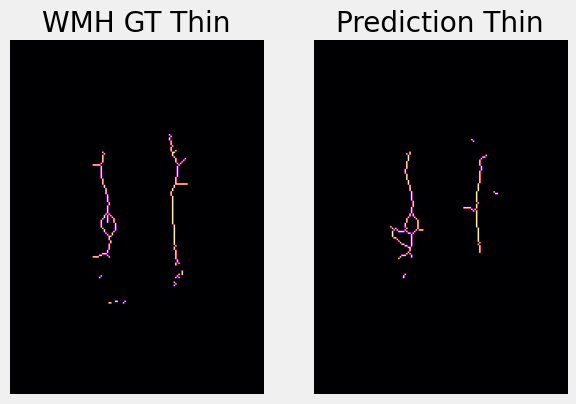

In [72]:
plt.subplot(1,2,1)
plt.imshow(gt_medial, cmap='magma'); plt.axis('off')
plt.title('WMH GT Thin')

plt.subplot(1,2,2)
plt.imshow(pred_medial, cmap='magma'); plt.axis('off')
plt.title('Prediction Thin');

In [73]:
## note these cells take a long time to run... the skeletonization algorithm is slow.
method=None
skeleton_ys = [torch.Tensor(skeletonize(y.numpy(), method=method)) for y in ys3d_ed]
skeleton_preds = [torch.Tensor(skeletonize(p.argmax(dim=1).type(torch.float32).numpy(), method=method)).type(torch.long) for p in preds]


skeleton_ys = [(s>0).type(torch.float32) for s in skeleton_ys]
skeleton_preds = [(s>0).type(torch.float32).type(torch.int64) for s in skeleton_preds]

3D skeletons looks very different


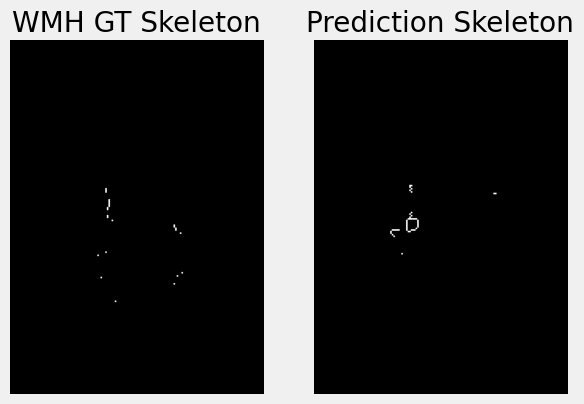

In [74]:
print("3D skeletons looks very different")
plt.subplot(1,2,1)
plt.imshow(skeleton_ys[scan_id][slice_id], cmap='gray'); plt.axis('off')
plt.title('WMH GT Skeleton')

plt.subplot(1,2,2)
plt.imshow(skeleton_preds[scan_id][slice_id], cmap='gray'); plt.axis('off')
plt.title('Prediction Skeleton');

In [75]:
def batch_thin(batch):
    return torch.stack([torch.Tensor(thin(bi)) for bi in batch])

In [76]:
thin_ys = [torch.Tensor(batch_thin(y.numpy())) for y in ys3d_ed]
thin_preds = [torch.Tensor(batch_thin(p.argmax(dim=1).type(torch.float32).numpy())).type(torch.long) for p in preds]

In [77]:
skeleton_data = per_model_chal_stats(skeleton_preds, skeleton_ys, False)

100%|██████████████████████████████████████████████████████| 180/180 [03:03<00:00,  1.02s/it]


In [78]:
#skeleton_data

In [79]:
thin_data = per_model_chal_stats(thin_preds, thin_ys, False)

100%|██████████████████████████████████████████████████████| 180/180 [03:06<00:00,  1.04s/it]


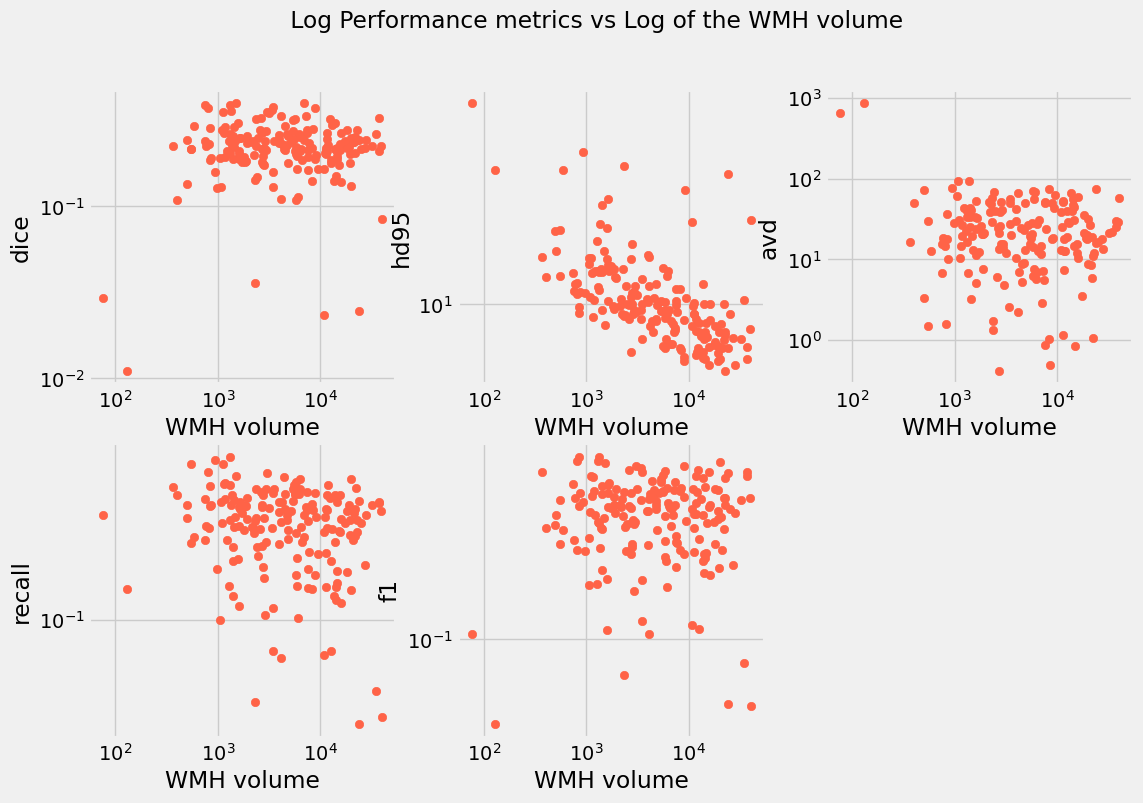

In [80]:
plot_data(skeleton_data, xlog=True, ylog=True, color='tomato')

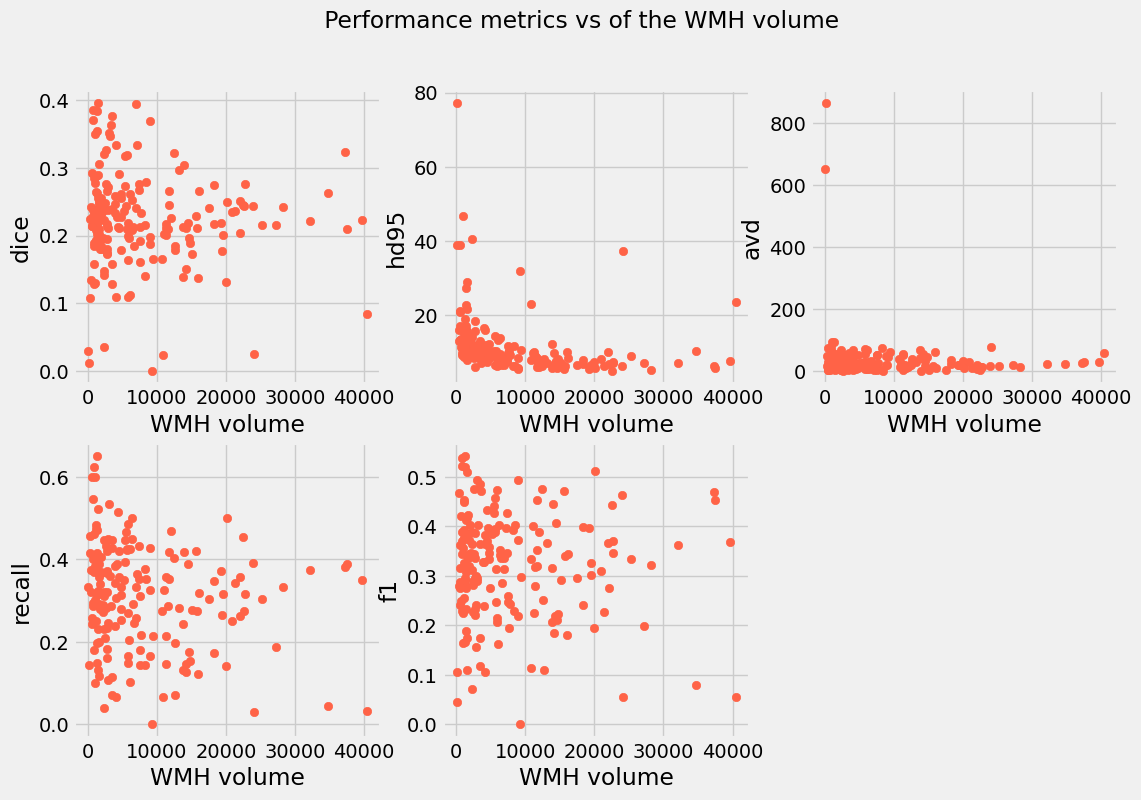

In [81]:
plot_data(skeleton_data, xlog=False, ylog=False, color='tomato')

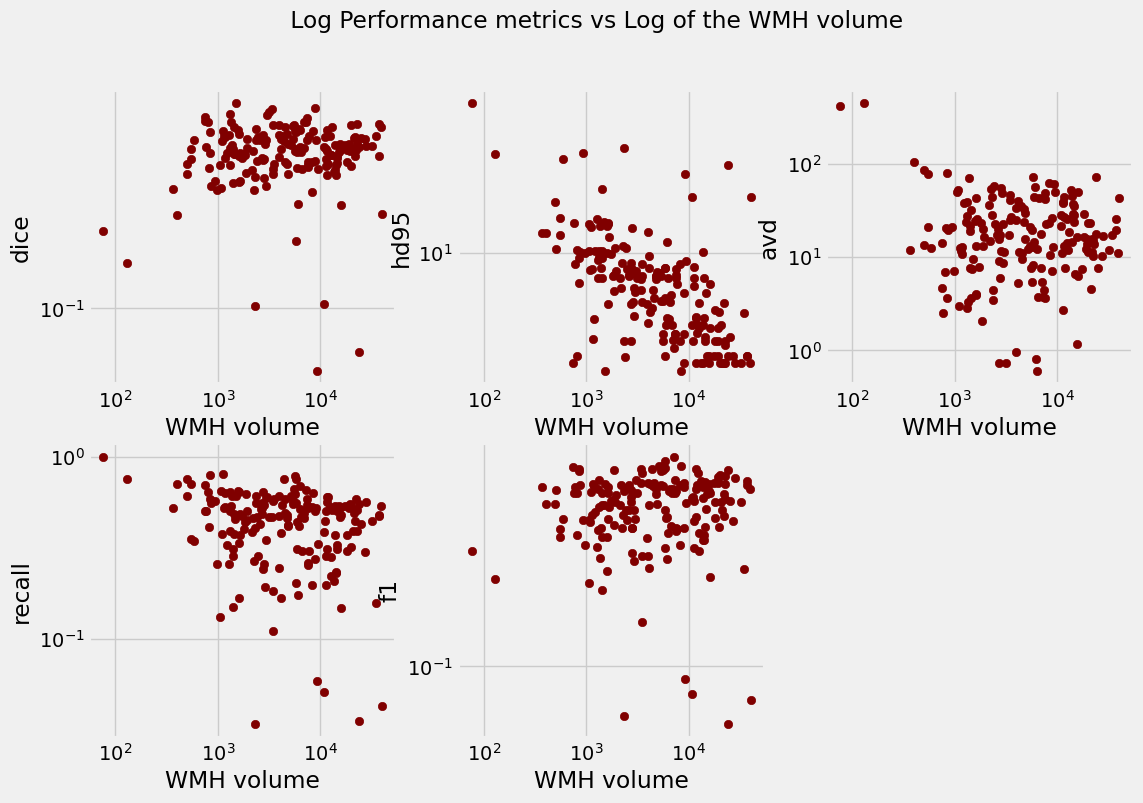

In [82]:
plot_data(thin_data, xlog=True, ylog=True, color='maroon')

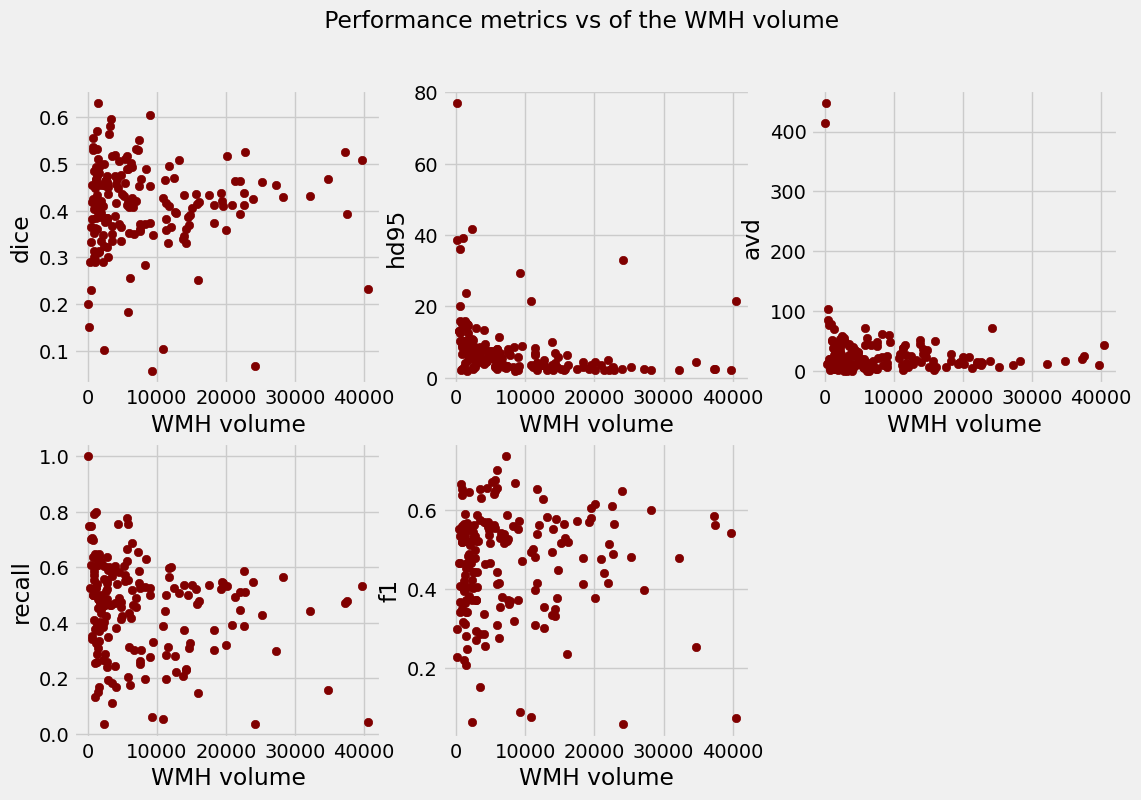

In [83]:
plot_data(thin_data, xlog=False, ylog=False, color='maroon')

### Brief thoughts
when looking at the skeleton log log, we see that we really do just get the straight line we are looking for in the dice. We also get a linear angled line in the HD95, but that isn't really meaningful I think if you don't have an outline edge but I need to check this. That is worth talking about, but essnentially, there looks like there is high varaince at low volumes, need more high volume examples to check, but essentially, the scans are not so bad at dealing with low volume scans overall.

Note thin is in 2D, skeleton is in 3D and I need to check the quality of the 3D skeletons (visualize them if I can). 

When not putting the volume on a log axis, now we just sees large variablility in low dice, but it doesn't degrade.

So it is essentially edges that are difficult by dice, but actually small lesions over all are not that difficult. Should also compare the 3D model performance.

### Connected components matching analysis

In [45]:
scan_id = 26
slice_id = 30

In [46]:
import cc3d

In [47]:
conn_comps = cc3d.connected_components(ys3d_ed[scan_id].numpy())

In [48]:
preds[0].shape

torch.Size([40, 2, 224, 160])

In [49]:
torch.as_tensor

<function torch._VariableFunctionsClass.as_tensor>

In [50]:
ys_conn_comps = [
    torch.as_tensor(
        cc3d.connected_components(
            y.numpy()
        ).astype(np.int32)
    )
    for y in tqdm(ys3d_ed, position=0)
]

preds_conn_comps = [
    torch.as_tensor(
        cc3d.connected_components(
            p.argmax(dim=1).numpy()
        ).astype(np.int32)
    )
    for p in tqdm(preds, position=0)
]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:44<00:00,  4.08it/s]


In [51]:
total = 0
for acc in ys_conn_comps:
    total += acc.unique().shape[0]

In [52]:
total

10544

In [133]:
def dilate_3d(img, dilation=2):
    img = img.unsqueeze(0).unsqueeze(0)
    if dilation%2 == 0:
        dilation = dilation + 1
        print("rounding up dilation to odd number")
    padding=(dilation // 2)
    img = torch.nn.functional.max_pool3d(img, kernel_size=dilation, padding=padding, stride=1, dilation=1)
    return img[0,0]
    
    
    

In [168]:
dilated = dilate_3d((all_conn_comps[scan_id]==2).type(torch.float32).cuda(),
                   dilation=9).cpu()

In [198]:
dilated_all_lesions = dilate_3d((all_conn_comps[scan_id]).type(torch.float32).cuda(),
                   dilation=9).cpu()

In [199]:
dilated.shape, all_conn_comps[scan_id].shape

(torch.Size([40, 224, 160]), torch.Size([40, 224, 160]))

In [200]:
dilated[slice_id].sum()

tensor(2586.)

Text(0.5, 0.98, 'dilation of an individual lesion with kernel width 9\n note: get bad overlapping if do all lesions together')

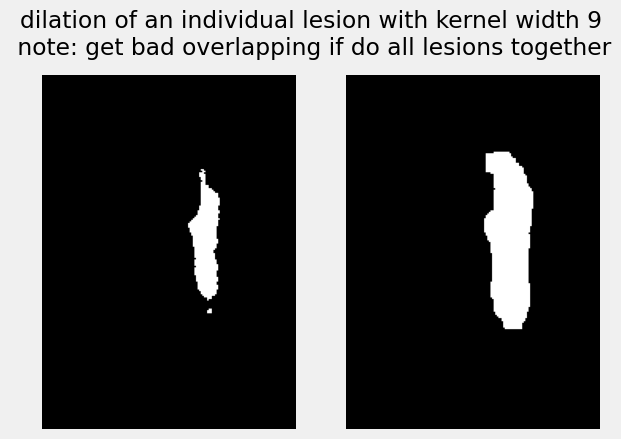

In [249]:

plt.subplot(1,2,1)
plt.imshow(all_conn_comps[scan_id][slice_id]==2, cmap='gray')
plt.axis('off');

plt.subplot(1,2,2)
plt.imshow(dilated[slice_id], cmap='gray')
# plt.imshow(dilated_all_lesions[slice_id]==2, cmap='tab20')
plt.axis('off');

plt.suptitle("dilation of an individual lesion with kernel width 9\n note: get bad overlapping if do all lesions together")

In [255]:
ys_conn_comps[scan_id][slice_id].unique(), preds_conn_comps[scan_id][slice_id].unique()

(tensor([ 0,  2,  3, 70, 71, 72, 73, 74], dtype=torch.int32),
 tensor([ 0,  5,  6, 52], dtype=torch.int32))

In [ ]:
### Look at matching of lesions one with the other
# can I do it by doing match of size, and assume each lesion is a sphere measure its radius in each axis...
# I can compute its IOU of circles efficiently maybe?

In [53]:
from collections import defaultdict
import time

In [56]:
def IOU(y_ccs, pred_ccs):
    return (y_ccs & pred_ccs).sum() / (y_ccs | pred_ccs).sum()

def ids_by_component_size(ccs):
    # get ids of each connected component, sorted by size descending
    # returns as list of ids
    # ignores the background index
    ids = ccs.unique()[1:] # skip the zero (background) index
    sizes = torch.zeros(ids.shape)
    for i, id in enumerate(ids):
        sizes[i] = (ccs==id).sum().cpu()
    
    size_sorted = torch.sort(sizes, descending=True)
    ids_sorted = ids[size_sorted[1]]
    
    return list(ids_sorted.cpu().numpy())


def IOU_selector(y_ccs, pred_ccs, greedy=False):
    # drastically increases the speed of the computation for doing the IOU
    y_ccs = y_ccs.cuda()
    pred_ccs = pred_ccs.cuda()
    
    # get ids of each connected component, sorted by size descending
    y_ids = ids_by_component_size(y_ccs)
    pred_ids = ids_by_component_size(pred_ccs)
    
    
    
    target_pred_matches = {}
    id_to_iou_map = {id:0 for id in pred_ids}

    for y_lesion_id in y_ids:
        if len(id_to_iou_map) == 0:
            target_pred_matches[y_lesion_id] = -1 # no more lesions left to match after greedy match
            continue 
        
        for pred_lesion_id in id_to_iou_map.keys():
            id_to_iou_map[pred_lesion_id] = IOU(y_ccs==y_lesion_id, pred_ccs==pred_lesion_id)
        
        # select best IOU
        # print(y_lesion_id)
        # print(id_to_iou_map.keys())
        # print(torch.Tensor(list(id_to_iou_map.values())))
        
        
        max_index = torch.Tensor(list(id_to_iou_map.values())).argmax()
        best_lesion_match_id = list(id_to_iou_map.keys())[max_index]
        target_pred_matches[y_lesion_id] = best_lesion_match_id
        
        if greedy:
            del id_to_iou_map[best_lesion_match_id]
        
    return target_pred_matches
    

In [60]:
start = time.time()
mapping = IOU_selector(ys_conn_comps[scan_id], preds_conn_comps[scan_id], greedy=False)
total = time.time() - start
print(total)

1.2450063228607178


Text(0.5, 0.98, 'target vs pred lesion')

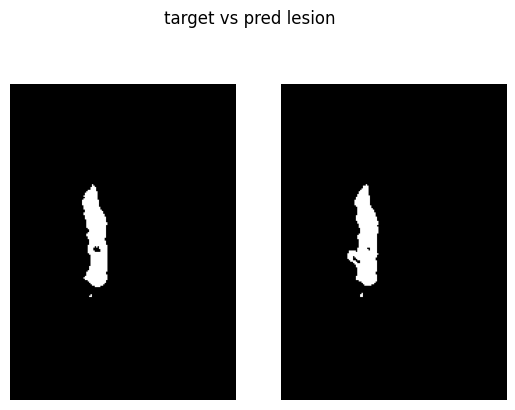

In [61]:
# target vs pred lesion

plt.subplot(1,2,1)
plt.imshow(ys_conn_comps[scan_id][slice_id]==3, cmap='gray')
plt.axis('off');

plt.subplot(1,2,2)
plt.imshow(preds_conn_comps[scan_id][slice_id]==mapping[3], cmap='gray')
# plt.imshow(dilated_all_lesions[slice_id]==2, cmap='tab20')
plt.axis('off');
plt.suptitle("target vs pred lesion")

In [69]:
import os, psutil
process = psutil.Process(os.getpid())
print(process.memory_info().rss)  # in bytes 


20806733824


In [78]:
# computing stats per individual lesion now. Then later we can idendity different
# lesion types hmm. Nice nice nice.
def per_lesion_chal_stats(ys_ccs, preds_ccs, batch, batch_size, results):
    # print(process.memory_info().rss / (1024 ** 2))
    stats = []
    per_ind_stats = []
    ys_ccs = ys_ccs[batch_size * batch : (batch + 1) * batch_size]
    preds_ccs = preds_ccs[batch_size * batch : (batch + 1) * batch_size]
    
    # print(process.memory_info().rss / (1024 ** 2))
    
    for i in tqdm(range(len(ys_ccs)), position=batch, leave=True):
        y = ys_ccs[i]
        p = preds_ccs[i]
        ind_stats = []
        
        # compute mapping that maps best prediction to each lesion
        mapping = IOU_selector(y, p, greedy=False)
        
        lesion_ids = list(y.unique().cpu().numpy())
        for id in lesion_ids:
            if id == 0:
                continue
            if id not in mapping or mapping[id] == -1:
                continue
            yi = y==id
            pi = p==mapping[id]
            
            # print(process.memory_info().rss / (1024 ** 2))
        
            lesion_stats = do_challenge_metrics(yi.type(torch.long), pi.type(torch.long))
            
            # print(process.memory_info().rss / (1024 ** 2))
            
            stats.append(lesion_stats)
            ind_stats.append(lesion_stats)
        
        per_ind_stats.append(ind_stats) #  we also collect a breakdown per individual.
        
        #print(process.memory_info().rss / (1024 ** 2))
        
    tstats = torch.Tensor(stats)
    dices = tstats[:,0]
    hd95s = tstats[:,1]
    avds = tstats[:,2]
    recalls = tstats[:,3]
    f1s = tstats[:,4]

    data = {"dice":dices, "hd95":hd95s, "avd":avds, "recall":recalls, "f1":f1s}
    
    results[batch] = (data, per_ind_stats)
    return

In [88]:
def collect_lesion_sizes(ys_ccs, preds_ccs):
    sizes = []
    un_matched_sizes = []
    
    # print(process.memory_info().rss / (1024 ** 2))
    
    for i in tqdm(range(len(ys_ccs)), position=0, leave=True):
        y = ys_ccs[i]
        p = preds_ccs[i]
        ind_stats = []
        
        # compute mapping that maps best prediction to each lesion
        mapping = IOU_selector(y, p, greedy=False)
        
        lesion_ids = list(y.unique().cpu().numpy())
        for id in lesion_ids:
            if id == 0:
                continue
            yi = y==id
            y_size = yi.sum()
            if id not in mapping or mapping[id] == -1:
                un_matched_sizes.append(y_size)
                continue
            pi = p==mapping[id]
            
            sizes.append(y_size)

    return sizes, un_matched_sizes

In [89]:
matched_sizes, unmatched_sizes = collect_lesion_sizes(ys_conn_comps, preds_conn_comps)

100%|██████████████████████████████████████████████████████| 180/180 [01:59<00:00,  1.51it/s]


In [98]:
def collect_lesion_surface_area(ys_ccs, preds_ccs):
    sizes = []
    un_matched_sizes = []
    
    # print(process.memory_info().rss / (1024 ** 2))
    
    for i in tqdm(range(len(ys_ccs)), position=0, leave=True):
        y = ys_ccs[i]
        p = preds_ccs[i]
        ind_stats = []
        
        # compute mapping that maps best prediction to each lesion
        mapping = IOU_selector(y, p, greedy=False)
        
        lesion_ids = list(y.unique().cpu().numpy())
        for id in lesion_ids:
            if id == 0:
                continue
            yi = y==id
            edge = get_edges(yi.type(torch.float32))
            y_size = edge.sum()
            if id not in mapping or mapping[id] == -1:
                un_matched_sizes.append(y_size)
                continue
            pi = p==mapping[id]
            
            sizes.append(y_size)

    return sizes, un_matched_sizes

In [99]:
matched_surfarea, unmatched_surfarea = collect_lesion_surface_area(ys_conn_comps, preds_conn_comps)

100%|██████████████████████████████████████████████████████| 180/180 [03:45<00:00,  1.25s/it]


In [147]:
def collect_lesion_hwd_ratio(ys_ccs, preds_ccs):
    sizes = []
    un_matched_sizes = []
    
    # print(process.memory_info().rss / (1024 ** 2))
    
    for i in tqdm(range(len(ys_ccs)), position=0, leave=True):
        y = ys_ccs[i]
        p = preds_ccs[i]
        ind_stats = []
        
        # compute mapping that maps best prediction to each lesion
        mapping = IOU_selector(y, p, greedy=False)
        
        lesion_ids = list(y.unique().cpu().numpy())
        for id in lesion_ids:
            if id == 0:
                continue
            yi = y==id
            
            xs, ys, zs = torch.where(yi)
            widths = torch.Tensor([xs.max() - xs.min(), ys.max() - ys.min(), zs.max() - zs.min()])
            widths = widths + 1 # "1 slice width" would otherwise have width of zero
            # get the ratio between the largest and smallest dimension widths
            y_size = widths.max() / widths.min()
            
            if id not in mapping or mapping[id] == -1:
                un_matched_sizes.append(y_size)
                continue
            pi = p==mapping[id]
            
            sizes.append(y_size)

    return sizes, un_matched_sizes

In [148]:
matched_ratios, unmatched_ratios = collect_lesion_hwd_ratio(ys_conn_comps, preds_conn_comps)

100%|██████████████████████████████████████████████████████| 180/180 [02:05<00:00,  1.44it/s]


In [132]:
xs, ys, zs = torch.where(ys_conn_comps[0]==1)

In [141]:
widths = torch.Tensor([xs.max() - xs.min(), ys.max() - ys.min(), zs.max() - zs.min()])

In [142]:
widths.max() / widths.min()

tensor(2.2000)

In [90]:
len(matched_sizes)

10364

In [79]:
n_batches = 1
batch_size = len(ys_conn_comps) // n_batches
batch_results = {}

per_lesion_chal_stats(ys_conn_comps, preds_conn_comps, 0, batch_size, batch_results)


100%|████████████████████████████████████████████████████| 180/180 [2:59:01<00:00, 59.67s/it]


In [81]:
results = batch_results[0]

In [83]:
results[0].keys()

dict_keys(['dice', 'hd95', 'avd', 'recall', 'f1'])

In [84]:
all_lesions_df = pd.DataFrame(results[0])

In [93]:
all_lesions_df["size"] = [m.item() for m in matched_sizes]

In [100]:
all_lesions_df["surface_area"] = [m.item() for m in matched_surfarea]

In [149]:
all_lesions_df["max_hwd_ratio"] = [m.item() for m in matched_ratios]

In [150]:
all_lesions_df

,dice,hd95,avd,recall,f1,size,surface_area,max_hwd_ratio
0,0.557377,8.320660,55.944057,1.0,1.0,143,122.0,2.000000
1,0.246154,12.051957,502.702698,1.0,1.0,37,35.0,3.000000
2,0.014079,106.519478,12957.376953,1.0,1.0,122,92.0,1.333333
3,0.125000,1.732051,93.333336,1.0,1.0,15,15.0,1.000000
4,0.592642,47.212288,53.366524,1.0,1.0,36759,14824.0,4.607143
...,...,...,...,...,...,...,...,...
10359,0.000000,90.221947,378850.000000,0.0,0.0,2,2.0,2.000000
10360,0.000000,67.557381,757800.000000,0.0,0.0,1,1.0,1.000000
10361,0.500000,1.000000,40.000000,1.0,1.0,5,5.0,1.500000
10362,0.000000,61.692787,757800.000000,0.0,0.0,1,1.0,1.000000


In [151]:
all_lesions_df.to_csv("per_lesion_results.csv")

In [159]:
np.arange(0, 10, 10/10)

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [163]:
np.logspace(0, 1, num=20, base=10)

array([ 1.        ,  1.12883789,  1.27427499,  1.43844989,  1.62377674,
        1.83298071,  2.06913808,  2.33572147,  2.6366509 ,  2.97635144,
        3.35981829,  3.79269019,  4.2813324 ,  4.83293024,  5.45559478,
        6.15848211,  6.95192796,  7.8475997 ,  8.8586679 , 10.        ])

In [161]:
np.log10(40000)

4.6020599913279625

In [157]:
# log base 10 of 40000 = 4.6
# 40000 is the max of the lesion size
points_500 = np.logspace(0, 4.6, num=500, base=10)
points_20 = np.logspace(0, 4.6, num=20, base=10)

In [172]:
torch.sort(torch.Tensor(all_lesions_df['size'].values))

torch.return_types.sort(
values=tensor([1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 2.6824e+04, 3.3765e+04,
        3.6759e+04]),
indices=tensor([3036, 8573, 2987,  ..., 1494, 4927,    4]))

In [190]:
def bin_values(df, x_name, y_name, num_bins=10, use_x_log=False):
    max = df[x_name].values.max()
    log_max = np.log10(max)
    
    if use_x_log:
        bin_markers = np.logspace(0, log_max, num=num_bins, base=10)
    else:
        width = max/num_bins
        bin_markers = np.arange(0, max+width, width)
        
    x_values = torch.Tensor(df[x_name].values)
    y_values = torch.Tensor(df[y_name].values)
    
    indices = torch.sort(x_values)[1]
    x_values = x_values[indices]
    y_values = y_values[indices]
    
    # filter values into each bin
    x_bins = []
    y_bins = []
    marker_idx = 0
    curr_marker = bin_markers[marker_idx]
    curr_x_bin = []
    curr_y_bin = []
    
    for i, v in enumerate(x_values):
        if v > curr_marker:
            x_bins.append(curr_x_bin)
            y_bins.append(curr_y_bin)
            curr_x_bin = []
            curr_y_bin = []
            marker_idx += 1
            curr_marker = bin_markers[marker_idx]
        
        curr_x_bin.append(v.item())
        curr_y_bin.append(y_values[i].item())
       
    x_means = [torch.Tensor(bin).mean() for bin in x_bins]
    y_means = [torch.Tensor(bin).mean() for bin in y_bins]
    y_stds = [torch.Tensor(bin).std() for bin in y_bins]
    
    return np.array(x_means), np.array(y_means), np.array(y_stds)
    

In [180]:
size, dice_mean, dice_std = bin_values(
    df=all_lesions_df,
    x_name='size', y_name='dice', num_bins=100, use_x_log=True
)

Text(0.5, 1.0, 'Dice of individual lesions')

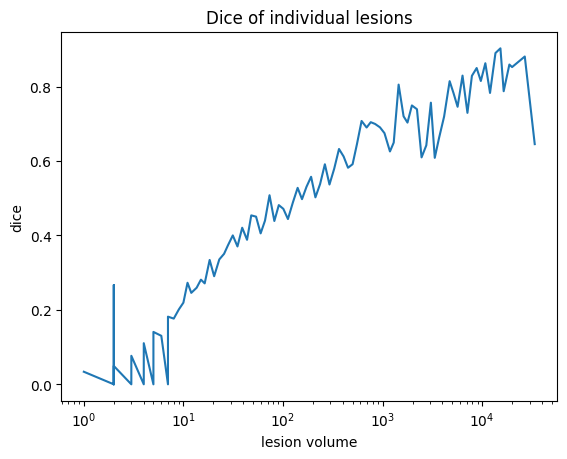

In [211]:
plt.plot(size, dice)
plt.xscale('log')
plt.xlabel("lesion volume")
plt.ylabel("dice")
plt.title("Dice of individual lesions")

In [208]:
size, avd_mean, _ = bin_values(
    df=all_lesions_df,
    x_name='size', y_name='avd', num_bins=100, use_x_log=True
)

Text(0.5, 1.0, 'AVD of individual lesion predictions')

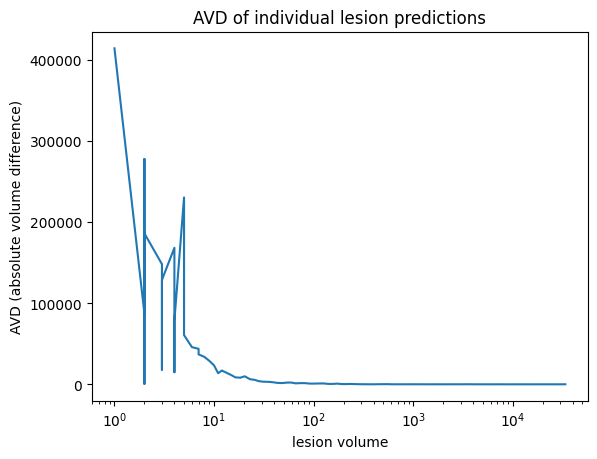

In [210]:
plt.plot(size, avd_mean)
plt.xscale('log')
plt.xlabel("lesion volume")
plt.ylabel("AVD (absolute volume difference)");
plt.title("AVD of individual lesion predictions")

***NOTE:***
what we are seeing is that the matching is sometimes poor for small lesions, so we get very high variability (becaues im matching every lesion, so some are being matched to much bigger predicted lesions sitting on top of them).

In [216]:
size, hd95_mean, _ = bin_values(
    df=all_lesions_df,
    x_name='size', y_name='hd95', num_bins=100, use_x_log=True
)

Text(0.5, 1.0, 'HD95 of individual lesions')

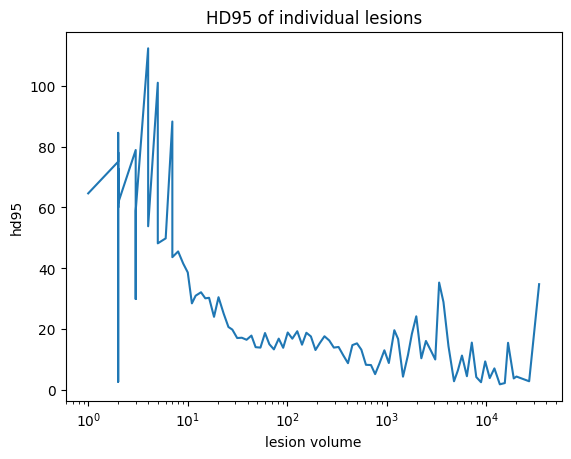

In [218]:
plt.plot(size, hd95_mean)
plt.xscale('log')
plt.xlabel("lesion volume")
plt.ylabel("hd95");
plt.title("HD95 of individual lesions")

In [196]:
max_hwd_ratio, dice_hdw, dice_hwd_std = bin_values(
    df=all_lesions_df,
    x_name='max_hwd_ratio', y_name='dice', num_bins=100, use_x_log=True
)

In [202]:
len(dice_hdw - dice_hwd_std), len(max_hwd_ratio)

(90, 90)

In [ ]:
plt.plot(max_hwd_ratio, dice_hdw)
#plt.fill_between(max_hwd_ratio, dice_hdw - dice_hwd_std, dice_hdw+dice_hwd_std, alpha=0.5)
plt.xscale('log')
plt.xlabel("elogation factor")
plt.ylabel("dice")
plt.title("Dice as lesions vary from\n

Text(0, 0.5, 'dice')

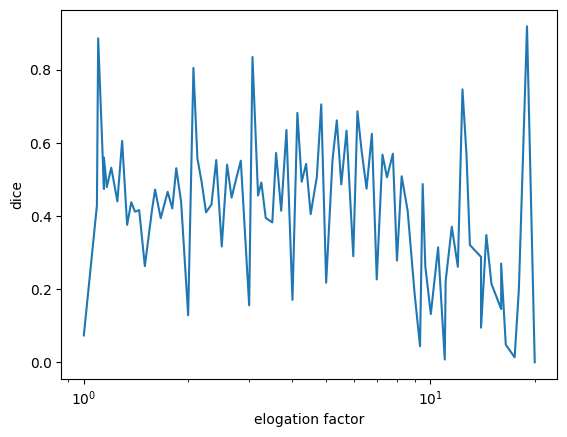

In [206]:
plt.plot(max_hwd_ratio, dice_hdw)
#plt.fill_between(max_hwd_ratio, dice_hdw - dice_hwd_std, dice_hdw+dice_hwd_std, alpha=0.5)
plt.xscale('log')
plt.xlabel("elogation factor")
plt.ylabel("dice")


In [213]:
max_hwd_ratio, avd_hdw, _ = bin_values(
    df=all_lesions_df,
    x_name='max_hwd_ratio', y_name='avd', num_bins=100, use_x_log=True
)

Text(0, 0.5, 'AVD')

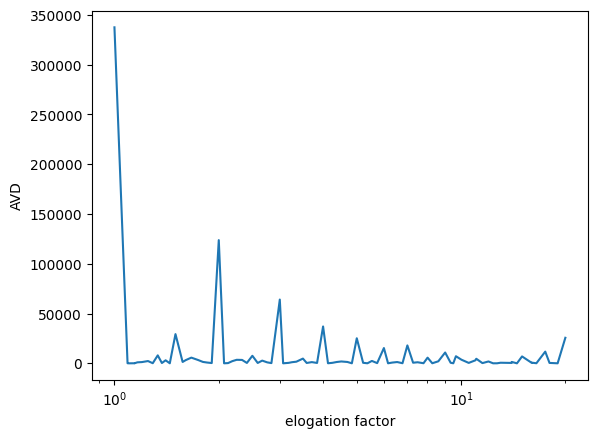

In [215]:
plt.plot(max_hwd_ratio, avd_hdw)
#plt.fill_between(max_hwd_ratio, dice_hdw - dice_hwd_std, dice_hdw+dice_hwd_std, alpha=0.5)
plt.xscale('log')
plt.xlabel("elogation factor")
plt.ylabel("AVD")

In [191]:
surface_area, dice_sfa, dice_sfa_std = bin_values(
    df=all_lesions_df,
    x_name='surface_area', y_name='dice', num_bins=100, use_x_log=True
)

In [193]:
dice_sfa_std

array([0.13336371,        nan,        nan,        nan,        nan,
              nan,        nan,        nan, 0.15632536,        nan,
              nan,        nan, 0.18816239,        nan,        nan,
       0.21975882,        nan, 0.23846447,        nan, 0.22913893,
              nan, 0.25401714, 0.2568337 , 0.27250445, 0.2743769 ,
       0.28454712, 0.26674837, 0.26910093, 0.28916308, 0.27926216,
       0.2921232 , 0.28365386, 0.28377718, 0.30385393, 0.28995466,
       0.2961322 , 0.28219926, 0.2899088 , 0.29027092, 0.2813847 ,
       0.2740127 , 0.27582884, 0.28904682, 0.28338662, 0.256915  ,
       0.2796685 , 0.2943811 , 0.2726469 , 0.28222463, 0.27244028,
       0.26778278, 0.25865662, 0.27038625, 0.24736689, 0.23375753,
       0.21415983, 0.23397817, 0.19960356, 0.2093159 , 0.18999933,
       0.18419603, 0.1902128 , 0.25295612, 0.16179024, 0.1159878 ,
       0.13326895, 0.13813198, 0.210578  , 0.09579027, 0.2568432 ,
       0.192707  , 0.12716205, 0.1680503 , 0.28224674, 0.11751

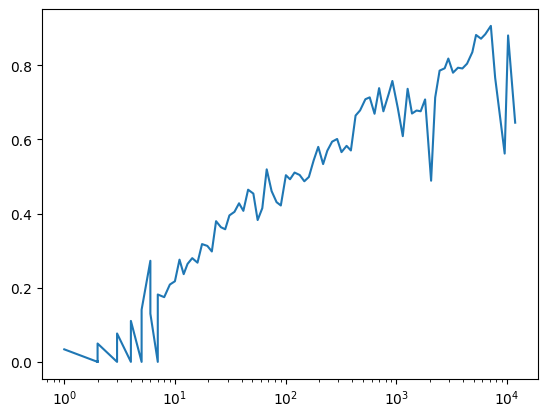

In [205]:
plt.plot(surface_area, dice_sfa)
#plt.fill_between(surface_area, dice_sfa - dice_sfa_std, dice_sfa+dice_sfa_std, alpha=0.5)
plt.xscale('log')

In [ ]:
# plotting over 10,000 points will cause a memory problem,
# so we should plot the mean and the variance of a bunch of points on a log scale.

In [92]:
### so to do the 3d connected component analysis for a single image
# we get the connected compoent mask, dilate it a bit so we get a capture region to compare it
# to another lesion since we dont have a match and then look at the
# overlap.
# Another method would be to do a matching algorithm where we match each lesion to another lesion and then compare that,.
# hmm



# okay so, one way that we could do this is to compare the skeletons using dice overlap
# of all the skeletons in the prediction with skeletons in the ground truth and take the lesions
# that contain that skeleton as the skeleton lesion predicted. I can then look at how many
# lesions in 3D are removed or added. Yes I quite like this but it is certainly quite a bit
# of work to get collected together, but it is a nice idea. Good.

# actually we can just do dice matching, which would be quickest I think.
# hmm. I might want to do it on GPU though to speed up the process...

# so get the connectd components for the scan and the prediction, and do pairwise greedy dice.
# greedy so we can remove from the list and carry on, nice. can use a map and use the index
# from the cc algorithm to denote each lesion and do greedy match nice.

In [ ]:
pred_conn_comps = 
y_conn_comps = 

(-0.5, 159.5, 223.5, -0.5)

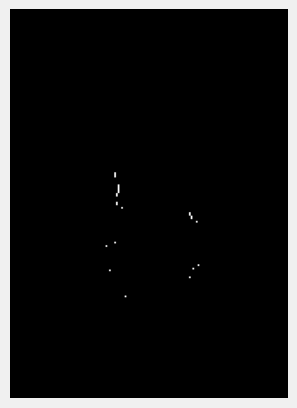

In [207]:
plt.imshow(skeleton_ys[scan_id][slice_id], cmap='gray');
plt.axis('off')



In [217]:
skeleton_components = torch.Tensor(cc3d.connected_components(skeleton_ys[scan_id].numpy()).astype(np.int32))

(-0.5, 159.5, 223.5, -0.5)

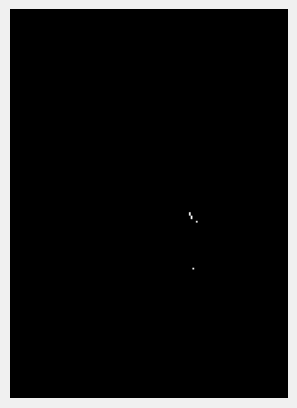

In [223]:
plt.imshow(skeleton_components[slice_id]==2, cmap='gray')
plt.axis('off')

In [224]:
skeleton_components.unique()

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
        42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.,
        56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69.,
        70., 71., 72., 73., 74., 75., 76., 77., 78., 79.])

In [210]:
all_conn_comps[scan_id].unique()

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
        42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.,
        56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69.,
        70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82., 83.,
        84., 85., 86., 87.])